In [155]:
# Dependencies
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import requests
import time
import json
import gmaps
import gmaps.datasets
import gmaps.geojson_geometries
import zipcodes
import censusgeocode as cg


import seaborn as sns

from census import Census
from us import states
import us

# census key
from api_keys import (ckey, gkey)

# Census API Key
c = Census(ckey, year=2013)

### Read csv from previously formatted data

In [37]:
incidents_df = pd.read_csv("Info/ZipcodeCleanIncidents.csv", dtype={'Zipcode': 'str'})
incidents_df.head()

,Unnamed: 0,Incident Date,State,City Or County,Address,# Killed,# Injured,ST,Zipcode,Latitude,Longitude,Population At Incident,Density,Type
0,0,2014-12-29,Louisiana,New Orleans,Poydras and Bolivar,0,4,LA,70113,30.06,-89.93,8011.0,6907.57,Urban
1,1,2014-12-27,California,Los Angeles,8800 block of South Figueroa Street,1,3,CA,90003,33.96,-118.27,66913.0,18661.22,Urban
2,2,2014-12-27,California,Sacramento,4000 block of May Street,0,4,CA,95838,38.64,-121.44,35935.0,4053.81,Urban
3,3,2014-12-26,Illinois,East St. Louis,2500 block of Summit Avenue,1,3,IL,62205,38.61,-90.13,8645.0,1847.33,Suburban
4,4,2014-12-24,Missouri,Saint Louis,18th and Pine,1,3,MO,63103,38.63,-90.24,6921.0,3195.92,Urban


In [38]:
# Check total amount of incidents to verify
len(incidents_df)

1331

In [39]:
# Rename and reorder dataframe
incidents_df["Victims"] = incidents_df["# Killed"] + incidents_df["# Injured"]
incidents_df = incidents_df.rename(columns={"City Or County":"City","# Killed":"Killed","# Injured":"Injured"})
incidents_df = incidents_df[["Incident Date","City","State","ST","Zipcode","Killed","Injured","Victims","Type","Latitude","Longitude","Population At Incident","Density"]]

# Preview to verify
incidents_df.head()

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density
0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57
1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22
2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81
3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33
4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92


### Group by Density Types for calculations

In [40]:
# Create grouped object by Density Type
densityType_group = incidents_df.groupby("Type")

#### Total incidents by density type

In [41]:
# Calculate total number of incidents per Density Type
incidentNumber = densityType_group["Zipcode"].count()
totalIncidients = incidentNumber.sum()

# Create dataframe from number of incidents by density type
shootingsByCityType=pd.DataFrame(incidentNumber)

# Rename columns, find percentages of number shot overall for each type
shootingsByCityType = shootingsByCityType.rename(columns={"Zipcode":"Total Incidents"})
shootingsByCityType["Percentage"] = shootingsByCityType["Total Incidents"]/totalIncidients*100
shootingsByCityType

,Total Incidents,Percentage
Type,,
Rural,271,21.056721
Suburban,269,20.901321
Urban,747,58.041958


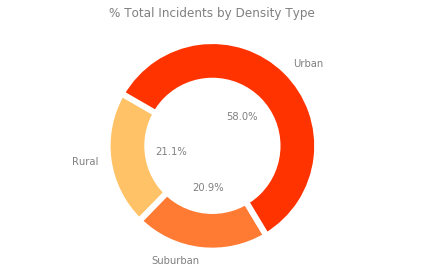

In [42]:
# Calculate Type Percents
fig, ax = plt.subplots()

ax.axis('equal')
totalShot = shootingsByCityType["Total Incidents"]

labels = shootingsByCityType.index
explode = (0, 0, 0)
colors = ['#ffc266', '#ff7a33', '#ff3300']

patches, texts, autotexts = ax.pie(totalShot, labels = labels, explode = explode, colors = colors, autopct="%1.1f%%", pctdistance = 0.4, startangle=150, wedgeprops = {'linewidth':6, 'edgecolor':'white', 'antialiased' : True})
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')

center_circle = plt.Circle((0,0), 0.65, fc = 'white')
fig1 = plt.gcf()
fig1.gca().add_artist(center_circle)
plt.title("% Total Incidents by Density Type", color = 'gray')

plt.tight_layout()

plt.savefig("Images/PercentTotalIncidentsPerDensity")
plt.show()

In [43]:
# Calculate the total number of victims(injured and killed) for each density type
victimCount = densityType_group.sum()

# Calculate and add column for percentage of vicitms killed for each density type and format
victimCount["Percentage of Victims Killed"] = victimCount["Killed"]/victimCount["Victims"]*100
victimCount["Percentage of Victims Killed"] = round(victimCount["Percentage of Victims Killed"], 2)

# Calculate and add column for percentage of vicitms injured for each density type and format
victimCount["Percentage of Victims Injured"] = victimCount["Injured"]/victimCount["Victims"]*100
victimCount["Percentage of Victims Injured"] = round(victimCount["Percentage of Victims Injured"], 2)

victimCount = victimCount.drop(['Latitude','Longitude','Density'], axis = 1)

# View to verify
victimCount

,Killed,Injured,Victims,Population At Incident,Percentage of Victims Killed,Percentage of Victims Injured
Type,,,,,,
Rural,468,1001,1469,6200410.0,31.86,68.14
Suburban,304,1077,1381,8006512.0,22.01,77.99
Urban,694,3532,4226,27569082.0,16.42,83.58


In [44]:
# Calculate percentages overall injured and killed overall for each desity type
totalKilled = victimCount["Killed"].sum()
totalInjured = victimCount["Injured"].sum()
totalVictims = victimCount["Victims"].sum()

victimCount["Percentage Overall Injured"] = victimCount["Injured"]/totalInjured*100
victimCount["Percentage Overall Injured"] = round(victimCount["Percentage Overall Injured"], 2)
victimCount["Percentage Overall Killed"] = victimCount["Killed"]/totalKilled*100
victimCount["Percentage Overall Killed"] = round(victimCount["Percentage Overall Killed"], 2)
victimCount["Percentage Overall Victims"] = victimCount["Victims"]/totalVictims*100
victimCount["Percentage Overall Victims"] = round(victimCount["Percentage Overall Victims"], 2)

# Preview to verify
victimCount

,Killed,Injured,Victims,Population At Incident,Percentage of Victims Killed,Percentage of Victims Injured,Percentage Overall Injured,Percentage Overall Killed,Percentage Overall Victims
Type,,,,,,,,,
Rural,468,1001,1469,6200410.0,31.86,68.14,17.84,31.92,20.76
Suburban,304,1077,1381,8006512.0,22.01,77.99,19.20,20.74,19.52
Urban,694,3532,4226,27569082.0,16.42,83.58,62.96,47.34,59.72


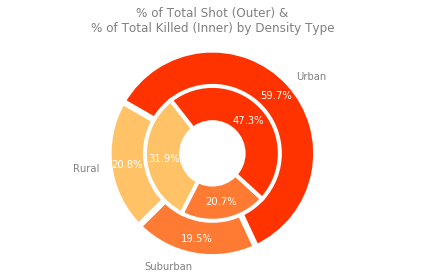

In [45]:
# Define plot area
fig, ax = plt.subplots()

# Define values to plot
ax.axis('equal')
totalShot = victimCount["Victims"]

labels = shootingsByCityType.index
explode = (0, 0, 0)
colors = ['#ffc266', '#ff7a33', '#ff3300']

# Create pie chart
patches, texts, autotexts = ax.pie(totalShot, labels = labels, explode = explode, colors = colors, autopct="%1.1f%%", pctdistance = 0.83, startangle=150, wedgeprops = {'linewidth':6, 'edgecolor':'white', 'antialiased' : True})
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('white')

plt.tight_layout()

totalKilled = victimCount["Killed"]

labels = victimCount.index
explode = (0, 0, 0)
colors = ['#ffc266', '#ff7a33', '#ff3300']

patches, texts, autotexts = ax.pie(totalKilled, explode = explode, colors = colors, autopct="%1.1f%%", radius = 0.65, pctdistance = .72, startangle=128, wedgeprops = {'linewidth':4, 'edgecolor':'white', 'antialiased' : True})
for text in texts:
    text.set_color('white')
for autotext in autotexts:
    autotext.set_color('white')

center_circle = plt.Circle((0,0), 0.32, fc = 'white')
fig3 = plt.gcf()
fig3.gca().add_artist(center_circle)
plt.title("% of Total Shot (Outer) &\n% of Total Killed (Inner) by Density Type", color = 'gray')

plt.tight_layout()

plt.savefig("Images/PercentOverallShotKilledDensity")

plt.show()

#### Look at shootings grouped by victim numbers per density type

In [128]:
# Look at victim count slices for density types
bins = [0, 4, 9, 14, 19, 24, 29, 34, 39, 100, 500]
labels = ["< 5", "5-10","10-15","15-20","20-25","25-30","30-35","35-40","40-100","100+"]

victimsByGroup = incidents_df.copy()
victimsByGroup["Victim Group"] = pd.cut(victimsByGroup["Victims"], bins = bins, labels = labels)
victimGroups = victimsByGroup.groupby("Victim Group")
victimGroupsByType = victimsByGroup.groupby(["Victim Group", "Type"])

In [130]:
victimGroupsByType.sum()

Killed  Injured  Victims  Latitude  Longitude  \
Victim Group Type                                                      
< 5          Rural      166.0    346.0    512.0   4529.92  -11352.25   
             Suburban   123.0    473.0    596.0   5239.72  -13510.76   
             Urban      267.0   1493.0   1760.0  16662.56  -39767.53   
5-10         Rural      244.0    493.0    737.0   4740.68  -11726.14   
             Suburban   137.0    514.0    651.0   4042.69  -10055.48   
             Urban      297.0   1397.0   1694.0  11033.91  -26370.10   
10-15        Rural        5.0     51.0     56.0    171.50    -469.01   
             Suburban    19.0     53.0     72.0    193.77    -534.99   
             Urban       14.0     72.0     86.0    298.45    -670.89   
15-20        Rural       22.0     50.0     72.0    160.35    -427.61   
             Suburban     NaN      NaN      NaN       NaN        NaN   
             Urban        5.0     57.0     62.0    125.18    -407.50   
20-25        Rural        4.0     16.0     20.0     31.09     -97.71   
             Suburban     NaN      NaN      NaN       NaN        NaN   
             Urban        2.0     19.0     21.0     26.63     -81.85   
25-30        Rural        0.0     25.0     25.0     34.72     -92.35   
             Suburban     9.0     18.0     27.0     31.56     -97.18   
             Urban        NaN      NaN      NaN       NaN        NaN   
30-35        Rural        NaN      NaN      NaN       NaN        NaN   
             Suburban     NaN      NaN      NaN       NaN        NaN   
             Urban        NaN      NaN      NaN       NaN        NaN   
35-40        Rural        NaN      NaN      NaN       NaN        NaN   
             Suburban    16.0     19.0     35.0     34.07    -117.25   
             Urban        NaN      NaN      NaN       NaN        NaN   
40-100       Rural       27.0     20.0     47.0     29.26     -98.06   
             Suburban     NaN      NaN      NaN       NaN        NaN   
             Urban        NaN      NaN      NaN       NaN        NaN   
100+         Rural        NaN      NaN      NaN       NaN        NaN   
             Suburban     NaN      NaN      NaN       NaN        NaN   
             Urban      109.0    494.0    603.0     64.58    -196.51   

                       Population At Incident     Density  
Victim Group Type                                          
< 5          Rural                  3047190.0    42844.94  
             Suburban               4430193.0   304634.27  
             Urban                 16561855.0  4942853.77  
5-10         Rural                  2954394.0    44876.43  
             Suburban               3420540.0   223967.03  
             Urban                 10481355.0  2834634.39  
10-15        Rural                   117991.0      740.69  
             Suburban                131504.0    12374.42  
             Urban                   276104.0    78580.31  
15-20        Rural                    46837.0     1311.75  
             Suburban                     NaN         NaN  
             Urban                   150692.0    31757.49  
20-25        Rural                    32501.0      978.98  
             Suburban                     NaN         NaN  
             Urban                    20108.0     3041.65  
25-30        Rural                      869.0      846.28  
             Suburban                  8614.0     2290.85  
             Urban                        NaN         NaN  
30-35        Rural                        NaN         NaN  
             Suburban                     NaN         NaN  
             Urban                        NaN         NaN  
35-40        Rural                        NaN         NaN  
             Suburban                 15661.0     1437.95  
             Urban                        NaN         NaN  
40-100       Rural                      628.0       67.46  
             Suburban                     NaN         NaN  
             Urban                    

In [64]:
# Preview 
victimsPerGroup = victimGroups["Victims"].sum()
fatalitiesPerGroup = victimGroups["Killed"].sum()
victimsPerGroup

Victim Group
< 5       2980
5-10      3168
10-15      214
15-20      134
20-25       41
25-30       52
30-35        0
35-40       35
40-100      47
100+       603
Name: Victims, dtype: int64

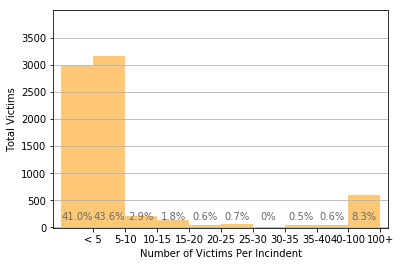

In [145]:
# Identify x-axis and y-axis, y min and ymax values from percent changes list
ymin = round(victimsPerGroup.min(), -1)
ymax = int(victimsPerGroup.max()/1000+1)*1000
x_axis = np.arange(1, len(victimsPerGroup)+1, 1)
y_axis = np.arange(ymin, ymax, 500)
   
# Create bar chart
fig, ax = plt.subplots()
ChangeBar = ax.bar(x_axis, victimsPerGroup, width = -1, align='edge', color = '#ffc266', alpha=0.9, ecolor='black')

# Modify x-axis values and labels
ax.set_xlim(-0.25, len(victimsPerGroup)+0.25)
ax.set_xticklabels(victimsPerGroup.index)
ax.set_xticks(x_axis)
ax.set_xlabel("Number of Victims Per Incindent")

# Modify y-axis values and labels
ax.set_ylim(ymin - 10, ymax + 10)
ax.set_yticks(y_axis)
ax.set_ylabel("Total Victims")

# Add grid and title
# ax.set_title("Victims By Victim Group")
ax.grid(axis='y')

# Label percentages on chart based on x-value and centered on each bar with a y coordinate determined
# by positive/negative value
xpos = 'center'
ha = {'center': 'center', 'right': 'left', 'left': 'right'}
offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

for rect in ChangeBar:
    height = rect.get_height()
    height = int(height)
    perc = height/victimsPerGroup.sum()*100
    perc = round(perc, 1)
    if perc > 0:
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 100,'{}'.format(perc)+'%', ha=ha[xpos], va='bottom', color = 'dimgray')
    elif perc == 0:
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 100,'{}'.format(0)+'%', ha=ha[xpos], va='bottom' , color = 'dimgray')

# Save graph
#plt.savefig("Images/IncidentsByVictimGroup")

# Show figure
plt.show()

#### Analyze yearly incidents/fatalities

In [148]:
# Separate dates to look at change over year
season_df = incidents_df.copy()

YrMo = [d.split("-") for d in season_df["Incident Date"]]
Yr = [t[0] for t in YrMo]
Mo = [t[1] for t in YrMo]

season_df["Year"] = Yr
season_df["Month"] = Mo
season_df.head()

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Year,Month
0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57,2014,12
1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22,2014,12
2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81,2014,12
3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33,2014,12
4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92,2014,12


In [1027]:
go = season_df.dropna()
# go["Incidents Per Capita"] = go["Incidents"]/go["Population At Incident"]*1000
go["Fatalities Per Capita"] = go["Killed"]/go["Population At Incident"]*1000
go["Victims Per Capita"] = go["Victims"]/go["Population At Incident"]*1000
go["Year"] = [int(x) for x in go["Year"]]
go["Month"] = [int(m) for m in go["Month"]]

dummies = pd.get_dummies(go['Type'])
go = pd.concat([go, dummies], axis=1)

go

C:\Users\lizma\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lizma\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\lizma\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Year,Month,Fatalities Per Capita,Victims Per Capita,Rural,Suburban,Urban
0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57,2014,12,0.000000,0.499313,0,0,1
1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22,2014,12,0.014945,0.059779,0,0,1
2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81,2014,12,0.000000,0.111312,0,0,1
3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33,2014,12,0.115674,0.462695,0,1,0
4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92,2014,12,0.144488,0.577951,0,0,1
5,2014-12-23,Winchester,Kentucky,KY,40391,1,3,4,Rural,37.99,-84.18,35351.0,147.27,2014,12,0.028288,0.113151,1,0,0
6,2014-12-22,Detroit,Michigan,MI,48215,1,3,4,Urban,42.38,-83.10,12606.0,3379.42,2014,12,0.079327,0.317309,0,0,1
7,2014-12-22,Webster,New York,NY,14580,4,2,6,Suburban,43.21,-77.42,50946.0,1187.60,2014,12,0.078515,0.117772,0,1,0
8,2014-12-22,Chicago,Illinois,IL,60621,0,5,5,Urban,41.83,-87.68,32619.0,9633.05,2014,12,0.000000,0.153285,0,0,1
9,2014-12-21,Sarasota,Florida,FL,34234,2,2,4,Suburban,27.33,-82.54,20349.0,2980.12,2014,12,0.098285,0.196570,0,1,0


In [1028]:
go.dtypes

Incident Date              object
City                       object
State                      object
ST                         object
Zipcode                    object
Killed                      int64
Injured                     int64
Victims                     int64
Type                       object
Latitude                  float64
Longitude                 float64
Population At Incident    float64
Density                   float64
Year                        int64
Month                       int64
Fatalities Per Capita     float64
Victims Per Capita        float64
Rural                       uint8
Suburban                    uint8
Urban                       uint8
dtype: object

In [1029]:
x_data = go[['Population At Incident', 'Density', 'Month', 'Year', 'Latitude', 'Rural', 'Suburban', 'Urban']]

y_data = go['Victims Per Capita']

##Adding constant term to the linear regression model
x_data = sm.add_constant(x_data)

model = sm.OLS(y_data, x_data).fit()
predictions = model.predict(x_data)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Victims Per Capita   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.768
Date:                Sat, 30 Mar 2019   Prob (F-statistic):           0.000472
Time:                        00:31:01   Log-Likelihood:                -4327.1
No. Observations:                1287   AIC:                             8670.
Df Residuals:                    1279   BIC:                             8712.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -535

In [149]:
# Separate data based on dates
df14 = season_df[season_df["Year"] == "2014"]
df15 = season_df[season_df["Year"] == "2015"]
df16 = season_df[season_df["Year"] == "2016"]
df17 = season_df[season_df["Year"] == "2017"]

In [151]:
# Group by months for use in graphing
df14m = df14.groupby("Month")
df15m = df15.groupby("Month")
df16m = df16.groupby("Month")
df17m = df17.groupby("Month")
dfAvg = season_df.groupby("Month")

# Calculate number of incidents per year per month
numberIncidents14 = df14m["Victims"].count()
totalVictims14 = df14m["Victims"].sum()
numberIncidents15 = df15m["Victims"].count()
numberIncidents16 = df16m["Victims"].count()
numberIncidents17 = df17m["Victims"].count()
numberIncidentsAvg = (numberIncidents14 + numberIncidents15 + numberIncidents16 + numberIncidents17)/4

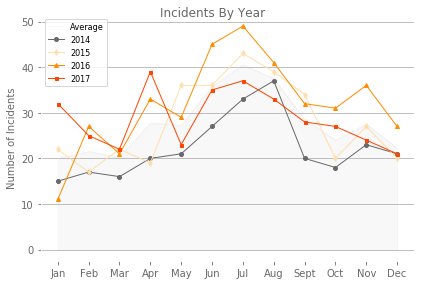

In [167]:
# Store x-axis and months in lists to use to plot graph
months = [m for m in np.arange(1, 13, 1)]
labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
xs = [x for x in range(0, len(labels))]
# Define graph box and title
with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
fig.suptitle("Incidents By Year", fontsize=12, color ='dimgray' )

# ax.bar(labels, numberIncidentsAvg, color = "lightgray", label = 'Average', alpha = .25)
ax.plot(labels, numberIncidentsAvg, color = "lightgray", marker = None, linewidth = .5, label = 'Average', alpha = .35)
ax.plot(labels, numberIncidents14, color = "dimgray", marker = 'o', markersize='4', linewidth = 1, label = '2014', )
ax.plot(labels, numberIncidents15, color = "navajowhite", marker = 'd', markersize='4', linewidth = 1, label = '2015')
ax.plot(labels, numberIncidents16, color = "darkorange", marker = '^',  markersize='4', linewidth = 1, label = '2016')
ax.plot(labels, numberIncidents17, color = "orangered", marker = 's', markersize='3', linewidth = 1, label = '2017')

d = sp.zeros(len(y))
ax.fill_between(xs, numberIncidentsAvg, interpolate=True, color='lightgray', alpha = .15)

# Set lables, legend, and grid
ax.grid(axis='y')
ax.legend(fontsize = 8)
ax.tick_params(colors='dimgray')
ax.set_ylabel("Number of Incidents", color ='dimgray' )
# ax.set_xlabel("Month", color ='dimgray' , fontsize = 10)
plt.tight_layout()

# Save graph
plt.savefig("Images/IncidentsOverYear")

# Show figure
plt.show()

In [169]:
# Calculate total fatalities per year per month
dfAvg = season_df.groupby("Month")
totFatal14 = df14m["Killed"].sum()
totalVictims14 = df14m["Killed"].sum()
totFatal15 = df15m["Killed"].sum()
totFatal16 = df16m["Killed"].sum()
totFatal17 = df17m["Killed"].sum()

# Calculate monthly average over 4 years
avgTotFatal14 = (totFatal14 + totFatal15 + totFatal16 + totFatal17)/4

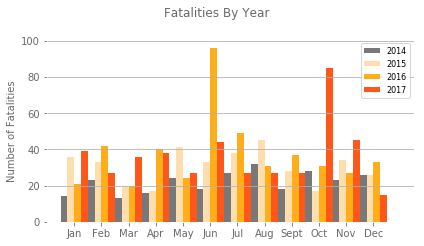

In [173]:
# Store months and x_axis in lists to use to plot graph
labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
monthsD = np.arange(0, len(labels), 1)
months = [float(m) for m in monthsD]

# Define graph box and title, set x limits and ticks
with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
fig.suptitle("Fatalities By Year", fontsize=12, x = .51, y = .93, color ='dimgray' )
ax.set_xticks(months)
ax.set_xlim(-1, 12.5)

# Define width to use and plot each year as bar chart
width = 0.25
ax.bar([(x-width) for x in months], totFatal14, -width, align='edge', alpha=0.9, ecolor='black', color = 'dimgray', label = "2014")
ax.bar([x for x in months], totFatal15, -width, align='edge', alpha=1, ecolor='black', color = 'navajowhite', label = "2015")
ax.bar([x for x in months], totFatal16, width, align='edge', alpha=0.9, ecolor='black', color = 'orange', label = "2016")
ax.bar([(x+width) for x in months], totFatal17, width, align='edge', alpha=0.9, ecolor='black', color = 'orangered', label = "2017")
# ax.plot(avgTotFatal14, linestyle=":")

# Set lables, legend, and grid
ax.grid(axis='y')
ax.legend(fontsize = 8)
ax.tick_params(colors='dimgray')
ax.set_aspect(1/15)
ax.set_xticklabels(labels)

ax.set_ylabel("Number of Fatalities", color ='dimgray' )
# ax.set_xlabel("Month", color ='dimgray' , fontsize = 10)
plt.tight_layout()

# Save graph
plt.savefig("Images/FatalitiesOverYear")

# Show figure
plt.show()

## Heatmaps

In [174]:
state_capitals = pd.read_csv("stateCapitals.csv", encoding = 'iso-8859-1')
state_capitals = state_capitals[["Unnamed: 1", "Unnamed: 2", "Unnamed: 4"]]
state_capitals = state_capitals.rename(columns = {"Unnamed: 1":"State","Unnamed: 2":"ST","Unnamed: 4":"Capital"})

In [175]:
state_capitals = state_capitals[1:51]
state_capitals = state_capitals.reset_index(drop = True)
latC = []
lonC = []
state_capitals.head()

,State,ST,Capital
0,Alabama,AL,Montgomery
1,Alaska,AK,Juneau
2,Arizona,AZ,Phoenix
3,Arkansas,AR,Little Rock
4,California,CA,Sacramento


In [176]:
for s in range(0, len(state_capitals)):

    target_city = (state_capitals["Capital"][s], state_capitals["State"][s])

    # Build the endpoint URL
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?'
        'address={0}&key={1}').format(target_city, gkey)
    geo_data = requests.get(target_url).json()
    latC.append(geo_data['results'][0]['geometry']['location']['lat'])
    lonC.append(geo_data['results'][0]['geometry']['location']['lng'])
    
# latC

In [177]:
state_capitals["Lat"] = latC
state_capitals["Lon"] = lonC
state_capitals.head()

,State,ST,Capital,Lat,Lon
0,Alabama,AL,Montgomery,32.379223,-86.307737
1,Alaska,AK,Juneau,58.301944,-134.419722
2,Arizona,AZ,Phoenix,33.448377,-112.074037
3,Arkansas,AR,Little Rock,34.746481,-92.289595
4,California,CA,Sacramento,38.581572,-121.494400


#### Total Incidents HeatMap

In [178]:
# Configure and define base map
gmaps.configure(api_key=gkey)
fig = gmaps.figure(center=(36.5, -98.5795), map_type = 'SATELLITE', zoom_level=4)

# Save geojson country and state outlines for reference
countries_geojson = gmaps.geojson_geometries.load_geometry('countries')
states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

# Create heatmap using total victims as weight
heatmap_layer = gmaps.heatmap_layer(
    incidents_df[["Latitude","Longitude"]], weights=incidents_df["Victims"], dissipating = False,
    opacity = 1, max_intensity=200, point_radius=2
)

# Configure state and country outlines
gini_layer1 = gmaps.geojson_layer(countries_geojson, fill_color=(217,217,217),fill_opacity=0,stroke_color=(153, 153, 153))
fig.add_layer(gini_layer1)
gini_layer = gmaps.geojson_layer(states_geojson, fill_color=(153, 153, 153),fill_opacity=.01, stroke_color=(153, 153, 153))
fig.add_layer(gini_layer)

# Define heatmap gradient
heatmap_layer.gradient = [
    '#ffffff',
    '#ff3300',
    '#ff7a33',
    '#ffc266'
]

# Add heatmap layer and view map
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### Calculate per capita by zipcode

In [180]:
# Add population numbers to dataframe and calculate per capita numbers
# urbanDensity_df["Popu/ion"] = [float(p) for p in urbanDensity_df["Population"]]

incidents_df["Victims Per Capita"] = incidents_df["Victims"] / incidents_df["Population At Incident"] * 1000
incidents_df["Victims Per Capita"] = round(incidents_df["Victims Per Capita"], 2)

incidents_df["Fatalities Per Capita"] = incidents_df["Killed"] / incidents_df["Population At Incident"] * 1000
incidents_df["Fatalities Per Capita"] = round(incidents_df["Fatalities Per Capita"], 2)

# Preview to verify
# urbanDensity_df["Population"].dtypes
incidents_df.head()

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Victims Per Capita,Fatalities Per Capita
0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57,0.50,0.00
1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22,0.06,0.01
2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81,0.11,0.00
3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33,0.46,0.12
4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92,0.58,0.14


#### Victims Per Capita HeatMap

In [181]:
# Configure and define base map
gmaps.configure(api_key=gkey)
fig = gmaps.figure(center=(36.5, -98.5795), map_type = 'SATELLITE', zoom_level=4)

# Save geojson country and state outlines for reference
countries_geojson = gmaps.geojson_geometries.load_geometry('countries')
states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

# Create heatmap using total victims as weight
heatmap_layer = gmaps.heatmap_layer(
    incidents_df[["Latitude","Longitude"]], weights=incidents_df["Victims Per Capita"]*100, dissipating = False,
    opacity = 1, max_intensity=1100, point_radius=2
)

# Configure state and country outlines
gini_layer1 = gmaps.geojson_layer(countries_geojson, fill_color=(217,217,217),fill_opacity=0,stroke_color=(153, 153, 153))
fig.add_layer(gini_layer1)
gini_layer = gmaps.geojson_layer(states_geojson, fill_color=(153, 153, 153),fill_opacity=.01, stroke_color=(153, 153, 153))
fig.add_layer(gini_layer)

# Define heatmap gradient
heatmap_layer.gradient = [
    '#ffffff',
    '#ff3300',
    '#ff7a33',
    '#ffc266'
]

# Add heatmap layer and view map
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

#### Fatalities PerCapita HeatMap

In [187]:
# Configure and define base map
gmaps.configure(api_key=gkey)
fig = gmaps.figure(center=(36.5, -98.5795), map_type = 'SATELLITE', zoom_level=4)

# Save geojson country and state outlines for reference
countries_geojson = gmaps.geojson_geometries.load_geometry('countries')
states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

# Create heatmap using total victims as weight
heatmap_layer = gmaps.heatmap_layer(
    incidents_df[["Latitude","Longitude"]], weights=incidents_df["Fatalities Per Capita"]*100, dissipating = False,
    opacity = 1, max_intensity=500, point_radius=2
)

# Configure state and country outlines
gini_layer1 = gmaps.geojson_layer(countries_geojson, fill_color=(217,217,217),fill_opacity=0,stroke_color=(153, 153, 153))
fig.add_layer(gini_layer1)
gini_layer = gmaps.geojson_layer(states_geojson, fill_color=(153, 153, 153),fill_opacity=.01, stroke_color=(153, 153, 153))
fig.add_layer(gini_layer)

# Define heatmap gradient
heatmap_layer.gradient = [
    '#ffffff',
    '#ff3300',
    '#ff7a33',
    '#ffc266'
]

# Add heatmap layer and view map
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

#### Incidents By Type Exporation

In [189]:
perCapitaByType = incidents_df.groupby("Type")
avgPerCapita = perCapitaByType.mean()
perCapitaCount = perCapitaByType.count()
perCapitaCount

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Latitude,Longitude,Population At Incident,Density,Victims Per Capita,Fatalities Per Capita
Type,,,,,,,,,,,,,,
Rural,271,271,271,271,271,271,271,271,271,271,271,271,271,271
Suburban,269,269,269,269,269,269,269,269,269,269,269,269,269,269
Urban,747,747,747,747,747,747,747,747,747,747,747,747,747,747


In [198]:
avgFatalitiesTypePC = avgPerCapita["Fatalities Per Capita"]
avgVictimsTypePC = avgPerCapita["Victims Per Capita"]
incidentCountType = perCapitaCount["Victims Per Capita"]
incidentCountType.index

Index(['Rural', 'Suburban', 'Urban'], dtype='object', name='Type')

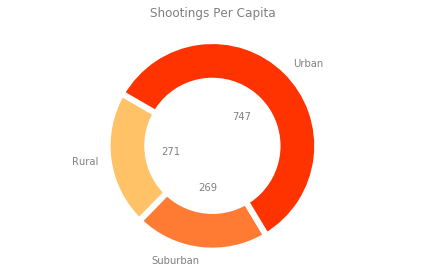

In [199]:
# Calculate Type Percents
fig, ax = plt.subplots()

ax.axis('equal')

labels = incidentCountType.index
explode = (0, 0, 0)
colors = ['#ffc266', '#ff7a33', '#ff3300']

patches, texts, autotexts = ax.pie(incidentCountType, labels = labels, explode = explode, colors = colors, autopct="%1.1f%%", pctdistance = 0.4, startangle=150, wedgeprops = {'linewidth':6, 'edgecolor':'white', 'antialiased' : True})
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')
for i, a in enumerate(autotexts):
    a.set_text("{}".format(incidentCountType[i]))

center_circle = plt.Circle((0,0), 0.65, fc = 'white')
fig1 = plt.gcf()
fig1.gca().add_artist(center_circle)
plt.title("Shootings Per Capita", color = 'gray')

plt.tight_layout()

plt.savefig("Images/ShootingsPerCapita")
plt.show()

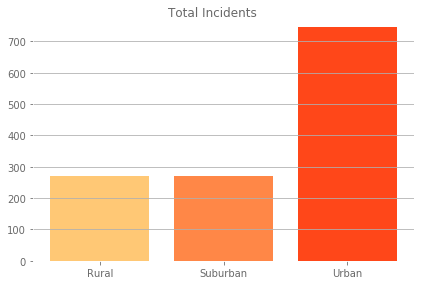

In [200]:
# Store x-axis and months in lists to use to plot graph
labels = incidentCountType.index
colors = ['#ffc266', '#ff7a33', '#ff3300']

# Define graph box and title
with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
fig.suptitle("Total Incidents", fontsize=12, color ='dimgray' )

for i in range(0, len(incidentCountType)):
    
    ax.bar(labels[i], incidentCountType[i], color = colors[i], alpha = .9 )

# Set lables, legend, and grid
ax.grid(axis='y')
ax.tick_params(colors='dimgray')
# ax.set_ylabel("Number of Incidents", color ='dimgray' )
#ax.set_xlabel("Month", color ='dimgray' , fontsize = 10)
plt.tight_layout()

# Save graph
plt.savefig("Images/IncidentsPerType_Bar")

# Show figure
plt.show()

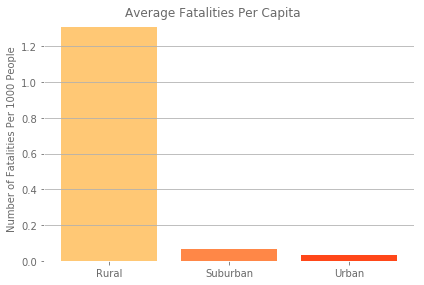

In [196]:
# Store x-axis and months in lists to use to plot graph
labels = avgFatalitiesTypePC.index
colors = ['#ffc266', '#ff7a33', '#ff3300']

# Define graph box and title
with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
fig.suptitle("Average Fatalities Per Capita", fontsize=12, color ='dimgray' )

for i in range(0, len(avgFatalitiesTypePC)):
    
    ax.bar(labels[i], avgFatalitiesTypePC[i], color = colors[i], alpha = .9 )

# Set lables, legend, and grid
ax.grid(axis='y')
ax.tick_params(colors='dimgray')
ax.set_ylabel("Number of Fatalities Per 1000 People", color ='dimgray' )
#ax.set_xlabel("Month", color ='dimgray' , fontsize = 10)
plt.tight_layout()

# Save graph
plt.savefig("Images/AverageFatalitiesPerCapitaByType")

# Show figure
plt.show()

# Pickup

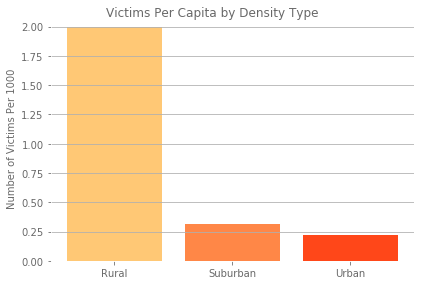

In [201]:
# Store x-axis and months in lists to use to plot graph
labels = avgVictimsTypePC.index
colors = ['#ffc266', '#ff7a33', '#ff3300']

# Define graph box and title
with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
fig.suptitle("Victims Per Capita by Density Type", fontsize=12, color ='dimgray' )

for i in range(0, len(avgVictimsTypePC)):
    
    ax.bar(labels[i], avgVictimsTypePC[i], color = colors[i], alpha = .9 )

# Set lables, legend, and grid
ax.grid(axis='y')
ax.tick_params(colors='dimgray')
ax.set_ylabel("Number of Victims Per 1000", color ='dimgray' )
#ax.set_xlabel("Month", color ='dimgray' , fontsize = 10)
plt.tight_layout()

# Save graph
plt.savefig("Images/VictimsPerCapitaByType")

# Show figure
plt.show()

In [202]:
incidents_df.head()

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Victims Per Capita,Fatalities Per Capita
0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57,0.50,0.00
1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22,0.06,0.01
2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81,0.11,0.00
3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33,0.46,0.12
4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92,0.58,0.14


In [498]:
plotData = incidents_df.copy()
plotDates = season_df.copy()
days = [a.split("-")[2] for a in plotDates["Incident Date"]]
plotDates["Day"] = days

for u in range(0, len(incidents_df)):
    if incidents_df["Victims"][u] > 550:
        plotData = plotData.drop(u)
        plotDates = plotDates.drop(u)
        
plotDates = plotDates.reset_index()
plotDates[989:992]

,index,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Year,Month,Day
989,989,2017-12-26,Miami,Florida,FL,33147,0,5,5,Urban,25.77,-80.20,47168.0,6475.30,2017,12,26
990,990,2017-12-24,Vicksburg,Mississippi,MS,39183,0,5,5,Rural,32.32,-90.87,14286.0,61.52,2017,12,24
991,991,2017-12-24,Troy,Alabama,AL,36081,1,4,5,Rural,31.80,-85.96,16091.0,70.25,2017,12,24


In [499]:
daysOfMonth = {}
daysOfMonthL = {}
months = [f for f in np.arange(1, 13, 1)]

length = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
lengthL = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

monthTotal = 0
monthTotalL = 0
monLength = []
monLengthL = []

for x in range(0, len(length)):
    monthTotal = monthTotal + length[x]
    monLength.append(monthTotal)
    monthTotalL = monthTotalL + lengthL[x]
    monLengthL.append(monthTotalL)
    
# monLength = [monthTot + length[x] for x in range(1, len(length))]
# monLength
for x in range(0, len(months)):
    daysOfMonth[x+1] = monLength[x]
    daysOfMonthL[x+1] = monLengthL[x]
    
# daysOfMonthL
DayDate = []
for y in range(0, len(plotDates)):
    yr = int(plotDates["Year"][y])
    mo = int(plotDates["Month"][y])
    dy = int(plotDates["Day"][y])
#     print(int(yr))
    if yr == 2016:
        DayDate.append(daysOfMonthL[mo] + dy)
    else:
        DayDate.append(daysOfMonth[mo] + dy)
        
# DayDate[0:5]
plotDates["YearInDays"] = DayDate
plotDates.head()
# daysOfMonthL[12]

,index,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Year,Month,Day,YearInDays
0,0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57,2014,12,29,394
1,1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22,2014,12,27,392
2,2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81,2014,12,27,392
3,3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33,2014,12,26,391
4,4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92,2014,12,24,389


In [500]:
plotDates["Victims Per Capita"] = incidents_df["Victims Per Capita"]
plotDates["Fatalities Per Capita"] = incidents_df["Fatalities Per Capita"]
# plotDates.head()
yearData = plotDates.groupby(["Type", "Year"])
yearCalcs = yearData.agg({"Victims":['sum'], "Victims Per Capita":['mean'], "Fatalities Per Capita":['mean']})
yearCalcs

Victims Victims Per Capita Fatalities Per Capita
                  sum               mean                  mean
Type     Year                                                 
Rural    2014     288           0.473455              0.142364
         2015     381           0.995600              0.429867
         2016     379           0.574667              0.252400
         2017     421           6.031212              4.487879
Suburban 2014     276           0.251964              0.052857
         2015     416           0.403562              0.084795
         2016     355           0.335890              0.077260
         2017     334           0.234925              0.041194
Urban    2014     732           0.232365              0.024122
         2015     863           0.193051              0.036045
         2016    1189           0.221735              0.036575
         2017    1442           0.237438              0.040345

In [501]:
yearCalcs.columns = yearCalcs.columns.droplevel(1)
yearCalcs

Victims  Victims Per Capita  Fatalities Per Capita
Type     Year                                                    
Rural    2014      288            0.473455               0.142364
         2015      381            0.995600               0.429867
         2016      379            0.574667               0.252400
         2017      421            6.031212               4.487879
Suburban 2014      276            0.251964               0.052857
         2015      416            0.403562               0.084795
         2016      355            0.335890               0.077260
         2017      334            0.234925               0.041194
Urban    2014      732            0.232365               0.024122
         2015      863            0.193051               0.036045
         2016     1189            0.221735               0.036575
         2017     1442            0.237438               0.040345

In [502]:
yearCalcs = yearCalcs.rename(columns={"Victims Per Capita":"Average Victims Per Capita","Fatalities Per Capita":"Average Fatalites Per Capita"})
yearCalcs

Victims  Average Victims Per Capita  \
Type     Year                                        
Rural    2014      288                    0.473455   
         2015      381                    0.995600   
         2016      379                    0.574667   
         2017      421                    6.031212   
Suburban 2014      276                    0.251964   
         2015      416                    0.403562   
         2016      355                    0.335890   
         2017      334                    0.234925   
Urban    2014      732                    0.232365   
         2015      863                    0.193051   
         2016     1189                    0.221735   
         2017     1442                    0.237438   

               Average Fatalites Per Capita  
Type     Year                                
Rural    2014                      0.142364  
         2015                      0.429867  
         2016                      0.252400  
         2017                      4.487879  
Suburban 2014                      0.052857  
         2015                      0.084795  
         2016                      0.077260  
         2017                      0.041194  
Urban    2014                      0.024122  
         2015                      0.036045  
         2016                      0.036575  
         2017                      0.040345

In [503]:
yearCalcs = yearCalcs.reset_index()

In [504]:
RuralC = yearCalcs[yearCalcs["Type"] == "Rural"]
SubC = yearCalcs[yearCalcs["Type"] == "Suburban"]
UrbC = yearCalcs[yearCalcs["Type"] == "Urban"]

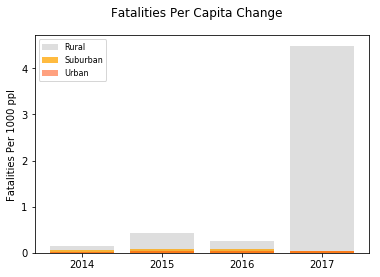

In [214]:
# Filter specific drugs to chart for mean Met. site data and associated standard error
years = RuralC["Year"]


# Store drug names, colors, marker formats in lists to use to plot graph
# drugNames = list(tumorSizes)
colors = ['coral','blue','green','black']
fmts = ["o","^","s","d"]

# Define graph box and title
fig, ax = plt.subplots()
fig.suptitle("Fatalities Per Capita Change", fontsize=12)

# Loop through index for each drug and plot graph using previously identified lists
# for i in range(0, len(RuralC)):
# ax.plot(years, RuralC["Average Victims Per Capita"],  color = 'lightgray', linewidth = 1)
# ax.plot(years, SubC["Average Victims Per Capita"],  color = 'orange', linewidth = 1)
# ax.plot(years, UrbC["Average Victims Per Capita"],  color = 'orangered', linewidth = 1)

ax.bar(years, RuralC["Average Fatalites Per Capita"],  color = 'lightgray', label = "Rural", alpha = .75)
ax.bar(years, SubC["Average Fatalites Per Capita"],  color = 'orange', label = "Suburban", alpha = .75)
ax.bar(years, UrbC["Average Fatalites Per Capita"],  color = 'orangered', label = "Urban", alpha = .5)


# Set lables, legend, and grid
# ax.grid()
ax.legend(fontsize = 8)
ax.set_ylabel("Fatalities Per 1000 ppl")
# ax.set_ylabel("Tumor Volume (mm3)")

# Save graph
# plt.savefig("Images/Tumor_Response_to_Treatment")

# Show figure
plt.show()

Text(0, 0.5, 'Victims Per 1000 ppl')

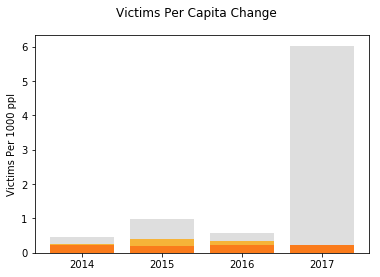

In [215]:
fig, ax = plt.subplots()
fig.suptitle("Victims Per Capita Change", fontsize=12)

ax.bar(years, RuralC["Average Victims Per Capita"],  color = 'lightgray', alpha = .75)
ax.bar(years, SubC["Average Victims Per Capita"],  color = 'orange', alpha = .75)
ax.bar(years, UrbC["Average Victims Per Capita"],  color = 'orangered', alpha = .5)

ax.set_ylabel("Victims Per 1000 ppl")

In [216]:
daysOfMonth.values()
# x_axis = [0]
x_axis = [x for x in daysOfMonth.values()]
# len(x[0])

In [505]:
stateGroup = incidents_df.groupby("State")
stateIncidents = stateGroup["Zipcode"].count()
stateVictims = stateGroup["Victims"].sum()
stateVictimsPC = stateGroup["Fatalities Per Capita"].mean()
len(stateIncidents)
stateData = pd.DataFrame(stateIncidents)
stateData["Victims"] = stateVictims
stateData["Average Fatalities Per Capita"] = stateVictimsPC

stateData.head()
# len(stateData)

,Zipcode,Victims,Average Fatalities Per Capita
State,,,
Alabama,26,140,0.106538
Alaska,1,6,0.000000
Arizona,16,80,0.102500
Arkansas,9,79,0.031111
California,150,776,0.045133


In [238]:
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT',
    'Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA',
    'Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI',
    'Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH',
    'New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK',
    'Oregon': 'OR','Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',
    'Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI',
    'Wyoming': 'WY', 'District of Columbia': 'DC' ,'Puerto Rico': 'PR'}

stateGradesData = pd.read_csv("Project1/gunlaw_scorecard.csv")
stateGradesData["ST"] = [us_state_abbrev[b] for b in stateGradesData["STATE"]]

stateGradesData.head()

,GUN LAW STRENGTH (RANKED),STATE,2018 GRADE,ST
0,37,Alabama,F,AL
1,44,Alaska,F,AK
2,46,Arizona,F,AZ
3,41,Arkansas,F,AR
4,1,California,A,CA


In [240]:
stateGradesData["LetterGr"] = [stateGradesData["2018 GRADE"][x][0] for x in range(0, len(stateGradesData))]
stateGradesData
stGrades = {}
abbLetGrade = {}

for x in range(0, len(stateGradesData)):
    stGrades[stateGradesData["STATE"][x]] = stateGradesData["LetterGr"][x]
    
for x in range(0, len(stateGradesData)):
    abbLetGrade[stateGradesData["ST"][x]] = stateGradesData["LetterGr"][x]
    
# stGrades
# abbLetGrade["AL"]

# for y in stGrades.keys():
 
stgrs = []

for s in stateData.index:
#     print(s)
    try:
        stgrs.append(stGrades[s])
        
    except:
        stgrs.append('N')
        
stgrs[0:5]

['F', 'F', 'F', 'F', 'A']

In [508]:
# 
x = plotData["Victims"][plotData["Type"]=="Rural"], plotData["Victims"][plotData["Type"]=="Suburban"], plotData["Victims"][plotData["Type"]=="Urban"]
y = plotData["Killed"][plotData["Type"]=="Rural"], plotData["Killed"][plotData["Type"]=="Suburban"], plotData["Killed"][plotData["Type"]=="Urban"]
z = plotData["Fatalities Per Capita"][plotData["Type"]=="Rural"], plotData["Fatalities Per Capita"][plotData["Type"]=="Suburban"], plotData["Fatalities Per Capita"][plotData["Type"]=="Urban"]
v = plotData["Victims Per Capita"][plotData["Type"]=="Rural"], plotData["Victims Per Capita"][plotData["Type"]=="Suburban"], plotData["Victims Per Capita"][plotData["Type"]=="Urban"]
d = plotDates["Month"][plotDates["Type"]=="Rural"], plotDates["Month"][plotDates["Type"]=="Suburban"], plotDates["Month"][plotDates["Type"]=="Urban"]
t = plotDates["YearInDays"][plotDates["Type"]=="Rural"], plotDates["YearInDays"][plotDates["Type"]=="Suburban"], plotDates["YearInDays"][plotDates["Type"]=="Urban"]
r = plotData["Killed"][plotData["Type"]=="Rural"]/plotData["Victims"][plotData["Type"]=="Rural"]*100, plotData["Killed"][plotData["Type"]=="Suburban"]/plotData["Victims"][plotData["Type"]=="Suburban"]*100, plotData["Killed"][plotData["Type"]=="Urban"]/plotData["Victims"][plotData["Type"]=="Urban"]*100

# z = z*4
# plotData

In [242]:
gradeNumbers = {'A':100, 'B':200, 'C':300, 'D':400, 'F':500, 'N':1}
g = [gradeNumbers[v] for v in stGrades.values()]
colors = {'A': "#ffe0b3",'B': "#ffcc99", 'C': "#ffa64d", 'D': "#ff8000", 'F': "#e65c00"}
col = [colors[v] for v in stGrades.values()]
gradeByZipcode = []
for g in plotData["State"]:
    try:
        gradeByZipcode.append(abbLetGrade[g])
    except:
        gradeByZipcode.append('N')
# gradeByZipcode = [abbLetGrade[g] for g in plotData["State"]]
sizeGrade = [gradeNumbers[n] for n in gradeByZipcode]
len(sizeGrade)
# gradeByZipcode[0:5]
# len(col)

1331

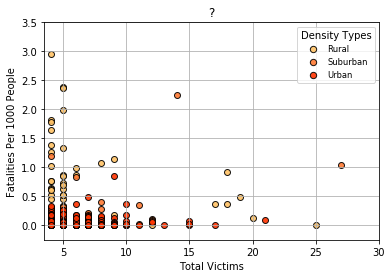

In [510]:
# Identify x, y, and scale values and create lists to reference when plotting
# x = urbanDensity_df["Total Victims"]
# y = urbanDensity_df["# Killed""]
#z = urbanDensity_df["# Killed"]


# Create a multiplier to emphasize the scale, and list colors and labels to use
#n = 10
colors = ['#ffc266', '#ff7a33', '#ff3300']
types = ["Rural","Suburban","Urban"]

# Loop through to plot each city type - reverse through the range
# to keep the order plotted with Urban in the back and Rural in the front
for j in (range(0, len(types))):
    plt.scatter(x[j], z[j],  color = colors[j], edgecolors = 'black', alpha = .9, label = types[j])

# Format plot with grid, labels, and legend
plt.grid()
plt.title("Death per Incident Size")
plt.xlabel("Total Victims Per Incident")
plt.xlim(3.5, 30)
plt.ylim(-0.25, 3.5)
# plt.xticks(x_axis, labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
plt.ylabel("Fatalities Per 1000 People")
# plt.figtext(.92, .62, "Note:\nCircle size correlates to gun law grade\nA: smallest\nF: largest")
lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
[handle.set_sizes([40]) for handle in lgnd.legendHandles]

# Save and print
#plt.savefig("RideShareScatterPlot")
plt.show()

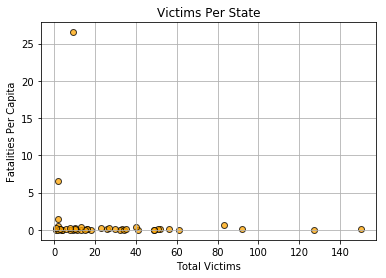

In [247]:
# Identify x, y, and scale values and create lists to reference when plotting
x = stateIncidents
y = stateVictims
z = stateVictimsPC

#n = 10
colors = ['#ffc266', '#ff7a33', '#ff3300']
# types = ["Rural","Suburban","Urban"]

plt.scatter(x, z, c = 'orange', edgecolors = 'black', alpha = .75)

# Format plot with grid, labels, and legend
plt.grid()
plt.title("Victims Per State")
plt.xlabel("Total Victims")

plt.ylabel("Fatalities Per Capita")

# plt.xlim(31, 397)
# plt.xticks(x_axis, labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
# plt.figtext(.92, .62, "Note:\nCircle size correlates to average fatalities per capita.")
# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]


# Save and print
#plt.savefig("RideShareScatterPlot")
plt.show()

### Gun law grades by state image

In [248]:
incidents_df.head()

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Victims Per Capita,Fatalities Per Capita
0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57,0.50,0.00
1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22,0.06,0.01
2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81,0.11,0.00
3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33,0.46,0.12
4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92,0.58,0.14


In [250]:
stateIncidents = incidents_df.groupby("State")
stCount = stateIncidents["Victims"].count()
stCount.head()

State
Alabama        28
Alaska          1
Arizona        16
Arkansas       10
California    152
Name: Victims, dtype: int64

In [253]:
colorOrange = {'A': "#ffe0b3",'B': "#ffcc99", 'C': "#ffa64d", 'D': "#ff8000", 'F': "#e65c00", 'N': "#ffffff"}
color = {'A': "#f2f2f2",'B': "#bfbfbf", 'C': "#999999", 'D': "#666666", 'F': "#333333", 'N': "#ffffff"}
colorGrey = {'A': "#f2f2f2",'B': "#d9d9d9", 'C': "#b3b3b3", 'D': "#999999", 'F': "#808080", 'N': "#ffffff"}
colors = []
testing = states_geojson['features'][0:5]
grades = []

for c in states_geojson['features']:
    
    try:
        
        st =c['properties']['NAME'] 
        grade = stGrades[st]
        hue = colorGrey[grade]
        colors.append(hue)

    except:
        
        grade = 'N'
        hue = colorGrey[grade]
        colors.append(hue)

#colors


In [254]:
gmaps.configure(api_key=gkey)
fig = gmaps.figure(center=(36.5, -98.5795), map_type = 'SATELLITE', zoom_level=4)

# Save geojson country and state outlines for reference
countries_geojson = gmaps.geojson_geometries.load_geometry('countries')
states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

# Configure state and country outlines
gini_layer = gmaps.geojson_layer(states_geojson, fill_color=colors,fill_opacity=1, stroke_color='#f2f2f2', stroke_weight = 2.0)
fig.add_layer(gini_layer)

gini_layer1 = gmaps.geojson_layer(countries_geojson, fill_color=(217,217,217),fill_opacity=0,stroke_color='#d9d9d9' )
fig.add_layer(gini_layer1)

# Create heatmap using total victims as weight
heatmap_layer = gmaps.heatmap_layer(
    incidents_df[["Latitude","Longitude"]], dissipating = False,
    opacity = 1, max_intensity=200, point_radius=2
)

# Define heatmap gradient
heatmap_layer.gradient = [
    '#ffffff',
    '#ffffff',
    '#ffffff',
    '#ffffff'
 ]

# Add heatmap layer and view map
fig.add_layer(heatmap_layer)
fig


Figure(layout=FigureLayout(height='420px'))

### Incidents by county exploration

In [442]:
countyData = pd.read_csv("Info/ShootingsByCountyData.csv")
countyData = countyData.rename(columns={"County_x":"County", "# Killed":"Killed","# Injured":"Injured", "Total Victims":"Victims"})
countyData = countyData.drop(["County_y", "Unnamed: 0"], axis=1)

list(countyData)

['State',
 'County',
 'Incidents',
 'Killed',
 'Injured',
 'County FIPS',
 'State FIPS',
 'Land Area',
 'Density 2014',
 'Density 2015',
 'Density 2016',
 'Density 2017',
 'Victims',
 'Population 2014',
 'Poverty Count 2014',
 'Poverty Rate 2014',
 'Population 2015',
 'Poverty Count 2015',
 'Poverty Rate 2015',
 'Population 2016',
 'Poverty Count 2016',
 'Poverty Rate 2016',
 'Population 2017',
 'Poverty Count 2017',
 'Poverty Rate 2017']

In [261]:
countyData.head()

,State,County,Incidents,Killed,Injured,County FIPS,State FIPS,Land Area,Density 2014,Density 2015,...,Poverty Rate 2014,Population 2015,Poverty Count 2015,Poverty Rate 2015,Population 2016,Poverty Count 2016,Poverty Rate 2016,Population 2017,Poverty Count 2017,Poverty Rate 2017
0,Alabama,Autauga,1,3,1,1,1,239.23,119.061155,117.426744,...,13.1,"54,860","6,966",12.7,"54,939","7,444",13.5,"55,021","7,390",13.4
1,Alabama,Blount,1,1,4,9,1,129.41,61.347655,62.174484,...,17.5,"57,116","8,399",14.7,"57,155","8,033",14.1,"57,452","7,343",12.8
2,Alabama,Calhoun,1,0,4,15,1,37.29,490.077769,497.291499,...,20.5,"112,727","22,579",20.0,"111,768","19,057",17.1,"111,883","19,832",17.7
3,Alabama,Chambers,1,2,7,17,1,87.92,138.159691,136.487716,...,21.3,"33,653","7,532",22.4,"33,378","6,656",19.9,"33,242","6,036",18.2
4,Alabama,Cherokee,1,3,1,19,1,62.39,70.844687,75.476839,...,18.6,"25,519","4,961",19.4,"25,389","4,273",16.8,"25,518","4,381",17.2


In [263]:
incidents_df.head()

,Incident Date,City,State,ST,Zipcode,Killed,Injured,Victims,Type,Latitude,Longitude,Population At Incident,Density,Victims Per Capita,Fatalities Per Capita
0,2014-12-29,New Orleans,Louisiana,LA,70113,0,4,4,Urban,30.06,-89.93,8011.0,6907.57,0.50,0.00
1,2014-12-27,Los Angeles,California,CA,90003,1,3,4,Urban,33.96,-118.27,66913.0,18661.22,0.06,0.01
2,2014-12-27,Sacramento,California,CA,95838,0,4,4,Urban,38.64,-121.44,35935.0,4053.81,0.11,0.00
3,2014-12-26,East St. Louis,Illinois,IL,62205,1,3,4,Suburban,38.61,-90.13,8645.0,1847.33,0.46,0.12
4,2014-12-24,Saint Louis,Missouri,MO,63103,1,3,4,Urban,38.63,-90.24,6921.0,3195.92,0.58,0.14


In [344]:
countyByZipcode = pd.read_csv("Info/CountyLocationData.csv")
countyByZipcode = countyByZipcode.drop(['Unnamed: 0','State FIPS', 'County FIPS','Zipcode'], axis=1)
countyByZipcode.head()

,Incident Date,County,State,Latitude,Longitude,# Killed,# Injured
0,2014-12-29,Orleans Parish,Louisiana,30.06,-89.93,0,4
1,2014-12-27,Los Angeles,California,33.96,-118.27,1,3
2,2014-12-27,Sacramento,California,38.64,-121.44,0,4
3,2014-12-26,St. Clair,Illinois,38.61,-90.13,1,3
4,2014-12-24,St. Louis City,Missouri,38.63,-90.24,1,3


In [345]:
len(countyByZipcode)

1331

In [346]:
countyByZipcode["Year"] = [countyByZipcode["Incident Date"][y][0:4] for y in range(0, len(countyByZipcode))]
countyByZipcode = countyByZipcode.drop(['Incident Date','Latitude','Longitude'], axis=1)
countyByZipcode.head()

,County,State,# Killed,# Injured,Year
0,Orleans Parish,Louisiana,0,4,2014
1,Los Angeles,California,1,3,2014
2,Sacramento,California,0,4,2014
3,St. Clair,Illinois,1,3,2014
4,St. Louis City,Missouri,1,3,2014


In [355]:
countyYear = countyByZipcode.groupby(['Year','State','County'])
countyYear = countyYear.agg({"# Killed":['sum'],"# Injured":['sum','count'] })
shootingsCountyYear = countyYear['# Injured'].rename(columns={"sum":"Injured","count":"Incidents"})
shootingsCountyYear['Killed'] = countyYear['# Killed']
shootingsCountyYear = shootingsCountyYear[["Incidents","Injured","Killed"]]
shootingsCountyYear['Victims'] = shootingsCountyYear['Injured'] + shootingsCountyYear['Killed']
shootingsCountyYear.head()


Incidents  Injured  Killed  Victims
Year State    County                                                     
2014 Alabama  Covington                       1        4       1        5
              Madison                         1        5       0        5
     Alaska   Anchorage Municipality          1        6       0        6
     Arizona  Maricopa                        1        3       1        4
     Arkansas Craighead                       1        4       4        8

In [356]:
len(shootingsCountyYear)

687

In [424]:
i = str("54,903")
i
# float(i)
i=i.replace(",", "")
float(i)

54903.0

In [443]:
countyData["Population 2014"] = [countyData["Population 2014"][i].replace(",", "") for i in range(0, len(countyData))]
countyData["Population 2014"] = [float(countyData["Population 2014"][n]) for n in range(0, len(countyData))]

countyData["Population 2015"] = [countyData["Population 2015"][i].replace(",", "") for i in range(0, len(countyData))]
countyData["Population 2015"] = [float(countyData["Population 2015"][n]) for n in range(0, len(countyData))]

countyData["Population 2016"] = [countyData["Population 2016"][i].replace(",", "") for i in range(0, len(countyData))]
countyData["Population 2016"] = [float(countyData["Population 2016"][n]) for n in range(0, len(countyData))]

countyData["Population 2017"] = [countyData["Population 2017"][i].replace(",", "") for i in range(0, len(countyData))]
countyData["Population 2017"] = [float(countyData["Population 2017"][n]) for n in range(0, len(countyData))]

In [444]:
county2014 = shootingsCountyYear.iloc[shootingsCountyYear.index.get_level_values('Year') == '2014']
county2015 = shootingsCountyYear.iloc[shootingsCountyYear.index.get_level_values('Year') == '2015']
county2016 = shootingsCountyYear.iloc[shootingsCountyYear.index.get_level_values('Year') == '2016']
county2017 = shootingsCountyYear.iloc[shootingsCountyYear.index.get_level_values('Year') == '2017']

In [445]:
county2014
couny = county2014.iloc[county2014.index.get_level_values('State') == 'Alabama']
couny.iloc[couny.index.get_level_values('County') == 'Covington']['Injured']

Year  State    County   
2014  Alabama  Covington    4
Name: Injured, dtype: int64

In [446]:
# shootingsCountyYear.iloc[:,(0)]

In [447]:
county2014.reset_index()
county2015.reset_index()
county2016.reset_index()
county2017.reset_index()
county2017.head()

Incidents  Injured  Killed  Victims
Year State   County                                        
2017 Alabama Autauga            1        1       3        4
             Chambers           1        7       2        9
             Jefferson          2       10       0       10
             None               1        4       0        4
             Pike               1        4       1        5

In [448]:
countStats14 = countyData[["State","County","Land Area","Density 2014","Poverty Rate 2014","Population 2014"]]
countStats15 = countyData[["State","County","Land Area","Density 2015","Poverty Rate 2015","Population 2015"]]
countStats16 = countyData[["State","County","Land Area","Density 2016","Poverty Rate 2016","Population 2016"]]
countStats17 = countyData[["State","County","Land Area","Density 2017","Poverty Rate 2017","Population 2017"]]


# countStats14.head()


In [449]:
counties2014 = pd.merge(county2014,countStats14, how='left', on=['State','County'] )
counties2015 = pd.merge(county2015,countStats15, how='left', on=['State','County'] )
counties2016 = pd.merge(county2016,countStats16, how='left', on=['State','County'] )
counties2017 = pd.merge(county2017,countStats17, how='left', on=['State','County'] )
counties2014.head()

,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2014,Poverty Rate 2014,Population 2014
0,Alabama,Covington,1,4,1,5,165.55,61.781939,20.8,37310.0
1,Alabama,Madison,1,5,0,5,9.15,2453.442623,14.2,342440.0
2,Alaska,Anchorage Municipality,1,6,0,6,NaN,NaN,NaN,NaN
3,Arizona,Maricopa,1,3,1,4,9.46,3554.016913,17.1,4023019.0
4,Arkansas,Craighead,1,4,4,8,117.22,473.775806,22.3,98729.0


In [450]:
counties2014.dtypes

State                 object
County                object
Incidents              int64
Injured                int64
Killed                 int64
Victims                int64
Land Area            float64
Density 2014         float64
Poverty Rate 2014    float64
Population 2014      float64
dtype: object

In [453]:
counties2014["Incidets/Capita"] = counties2014["Incidents"] / counties2014["Population 2014"] * 100000
counties2015["Incidets/Capita"] = counties2015["Incidents"] / counties2015["Population 2015"] * 10000
counties2016["Incidets/Capita"] = counties2016["Incidents"] / counties2016["Population 2016"] * 10000
counties2017["Incidets/Capita"] = counties2017["Incidents"] / counties2017["Population 2017"] * 10000

counties2014["Victims/Capita"] = counties2014["Victims"] / counties2014["Population 2014"] * 100000
counties2015["Victims/Capita"] = counties2015["Victims"] / counties2015["Population 2015"] * 10000
counties2016["Victims/Capita"] = counties2016["Victims"] / counties2016["Population 2016"] * 10000
counties2017["Victims/Capita"] = counties2017["Victims"] / counties2017["Population 2017"] * 10000

counties2014["Killed/Capita"] = counties2014["Killed"] / counties2014["Population 2014"] * 100000
counties2015["Killed/Capita"] = counties2015["Killed"] / counties2015["Population 2015"] * 10000
counties2016["Killed/Capita"] = counties2016["Killed"] / counties2016["Population 2016"] * 10000
counties2017["Killed/Capita"] = counties2017["Killed"] / counties2017["Population 2017"] * 10000

In [454]:
counties2017.head()

,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2017,Poverty Rate 2017,Population 2017,Incidets/Capita,Victims/Capita,Killed/Capita
0,Alabama,Autauga,1,1,3,4,239.23,118.024495,13.4,55021.0,0.181749,0.726995,0.545246
1,Alabama,Chambers,1,7,2,9,87.92,132.745678,18.2,33242.0,0.300824,2.707418,0.601649
2,Alabama,Jefferson,2,10,0,10,28.67,1688.803627,16.7,643726.0,0.031069,0.155346,0.000000
3,Alabama,None,1,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Pike,1,4,1,5,217.33,74.039479,27.7,31085.0,0.321699,1.608493,0.321699


In [531]:
data14 = pd.DataFrame(counties2014)
data15 = pd.DataFrame(counties2015)
data16 = pd.DataFrame(counties2016)
data17 = pd.DataFrame(counties2017)
data17.head()

,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2017,Poverty Rate 2017,Population 2017,Incidets/Capita,Victims/Capita,Killed/Capita,Fatality Rate
0,Alabama,Autauga,1,1,3,4,239.23,118.024495,13.4,55021.0,0.181749,0.726995,0.545246,75.000000
1,Alabama,Chambers,1,7,2,9,87.92,132.745678,18.2,33242.0,0.300824,2.707418,0.601649,22.222222
2,Alabama,Jefferson,2,10,0,10,28.67,1688.803627,16.7,643726.0,0.031069,0.155346,0.000000,0.000000
3,Alabama,None,1,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,Alabama,Pike,1,4,1,5,217.33,74.039479,27.7,31085.0,0.321699,1.608493,0.321699,20.000000


In [532]:
data14["Fatality Rate"] = data14["Killed"]/data14["Victims"]*100
data15["Fatality Rate"] = data15["Killed"]/data15["Victims"]*100
data16["Fatality Rate"] = data16["Killed"]/data16["Victims"]*100
data17["Fatality Rate"] = data17["Killed"]/data17["Victims"]*100


In [533]:
data17.head()

,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2017,Poverty Rate 2017,Population 2017,Incidets/Capita,Victims/Capita,Killed/Capita,Fatality Rate
0,Alabama,Autauga,1,1,3,4,239.23,118.024495,13.4,55021.0,0.181749,0.726995,0.545246,75.000000
1,Alabama,Chambers,1,7,2,9,87.92,132.745678,18.2,33242.0,0.300824,2.707418,0.601649,22.222222
2,Alabama,Jefferson,2,10,0,10,28.67,1688.803627,16.7,643726.0,0.031069,0.155346,0.000000,0.000000
3,Alabama,None,1,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,Alabama,Pike,1,4,1,5,217.33,74.039479,27.7,31085.0,0.321699,1.608493,0.321699,20.000000


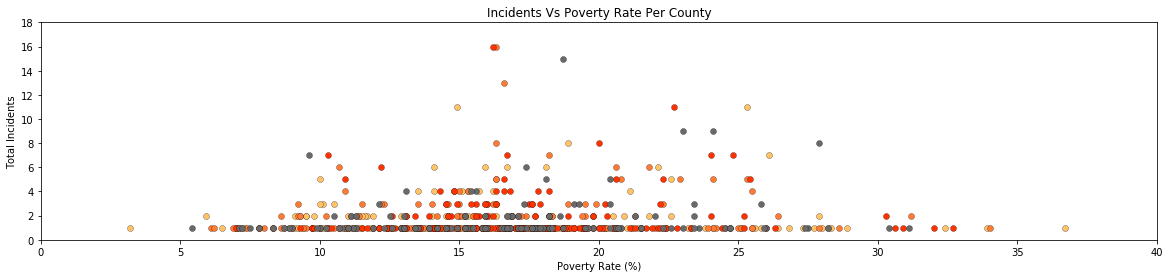

In [545]:
# Identify x, y, and scale values and create lists to reference when plotting
x = [data17["Incidents"], data16["Incidents"], data15["Incidents"], data14["Incidents"]]
y = [data17["Poverty Rate 2017"], data16["Poverty Rate 2016"], data15["Poverty Rate 2015"], data14["Poverty Rate 2014"]]
z = [data17["Fatality Rate"], data16["Fatality Rate"], data15["Fatality Rate"], data14["Fatality Rate"]]

#n = 10
colors = ['#ffc266', '#ff7a33', '#ff3300', 'dimgray']
# types = ["Rural","Suburban","Urban"]
# s=z[i]*0.01,

plt.figure(figsize=(20,4))
for i in range(0, len(x)):
    plt.scatter(y[i], x[i],  c = colors[i], edgecolors = 'black', linewidths=.25)

# Format plot with grid, labels, and legend
# plt.grid()
plt.title("Incidents Vs Poverty Rate Per County")
plt.xlabel("Poverty Rate (%)")

plt.ylabel("Total Incidents")

plt.xlim(0, 40)
plt.ylim(0, 18)
# plt.xticks(x_axis, labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
# plt.figtext(.92, .62, "Note:\nCircle size correlates to average fatalities per capita.")
# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]


# Save and print
#plt.savefig("RideShareScatterPlot")
plt.show()

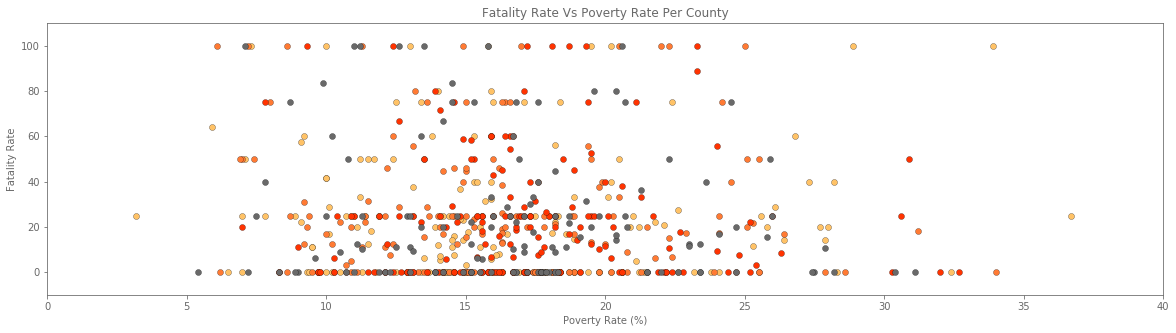

In [588]:
# Identify x, y, and scale values and create lists to reference when plotting
x = [counties2017["Incidents"], counties2016["Incidents"], counties2015["Incidents"], counties2014["Incidents"]]
y = [counties2017["Poverty Rate 2017"], counties2016["Poverty Rate 2016"], counties2015["Poverty Rate 2015"], counties2014["Poverty Rate 2014"]]
# z = [counties2017["Density 2017"], counties2016["Density 2016"], counties2015["Density 2015"], counties2014["Density 2014"]]

#n = 10
colors = ['#ffc266', '#ff7a33', '#ff3300', 'dimgray']
# types = ["Rural","Suburban","Urban"]
# s=z[i]*0.01,

with plt.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
# fig.suptitle("Metastatic Spread During Treatment", fontsize=12, x = .51, y = .93)
fig.set_size_inches(20, 5, forward=True)

for i in range(0, len(x)):
    ax.scatter(y[i], z[i], c = colors[i], edgecolors = 'black', linewidths=.25)

# Format plot with grid, labels, and legend
# plt.grid()
# plt.title("Incidents Vs Poverty Rate Per County")
ax.set_xlabel("Poverty Rate (%)", color = 'dimgray')
ax.set_ylabel("Fatality Rate", color = 'dimgray')
ax.tick_params( colors='dimgray')

ax.set_xlim(0, 40)
ax.set_ylim(-10, 110)

plt.title(f"Fatality Rate Vs Poverty Rate Per County", fontsize=12, color = 'dimgray')
# plt.xticks(x_axis, labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
# plt.figtext(.92, .62, "Note:\nCircle size correlates to average fatalities per capita.")
# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]


# Save and print
#plt.savefig("RideShareScatterPlot")
plt.show()

ValueError: x and y must be the same size

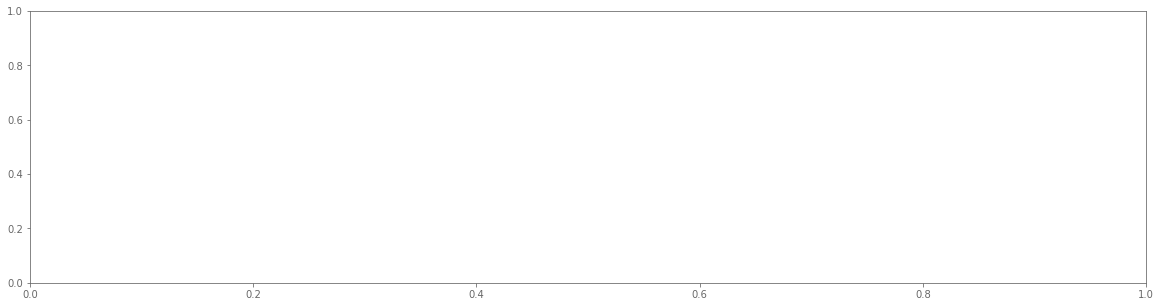

In [1053]:
x = [counties2017["Incidets/Capita"], counties2016["Incidets/Capita"], counties2015["Incidets/Capita"], counties2014["Incidets/Capita"]]
# y = [counties2017["County"], counties2016["County"], counties2015["County"], counties2014["County"]]
# y = [2017,2016,2015,2014]
with plt.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
# fig.suptitle("Metastatic Spread During Treatment", fontsize=12, x = .51, y = .93)
fig.set_size_inches(20, 5, forward=True)

for i in range(0, len(x)):
    ax.scatter(y[i], x[i], c = colors[i])

# Format plot with grid, labels, and legend
# plt.grid()
# plt.title("Incidents Vs Poverty Rate Per County")
ax.set_xlabel("Poverty Rate (%)", color = 'dimgray')
ax.set_ylabel("Incients Per Capita", color = 'dimgray')
ax.tick_params(colors='dimgray', bottom=False, labelbottom = False )

# ax.set_xlim(0, 40)
ax.set_ylim(-0.25,8)
# ax.set_xticks(rotate = 90)
# plt.title(f"Fatality Rate Vs Poverty Rate Per County", fontsize=12, color = 'dimgray')
# plt.xticks(x_axis, labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
# plt.figtext(.92, .62, "Note:\nCircle size correlates to average fatalities per capita.")
# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]


# Save and print
#plt.savefig("RideShareScatterPlot")
plt.show()

ValueError: x and y must be the same size

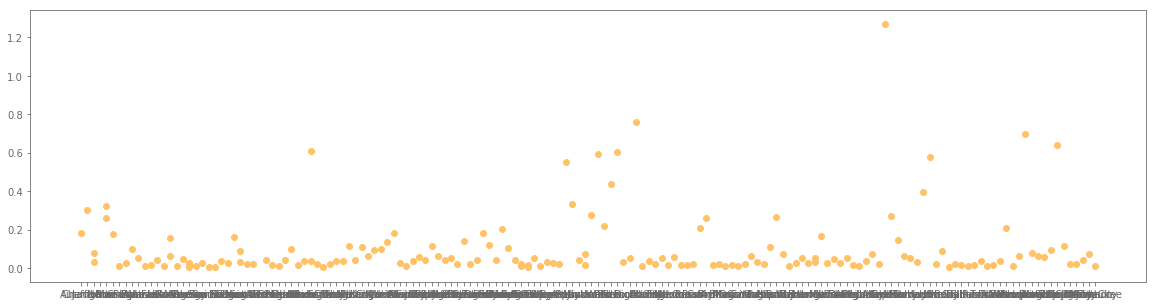

In [629]:
# x = [counties2017["Incidets/Capita"], counties2016["Incidets/Capita"], counties2015["Incidets/Capita"], counties2014["Incidets/Capita"]]
# y = [counties2017["County"], counties2016["County"], counties2015["County"], counties2014["County"]]
# y = [2017,2016,2015,2014]

x = [data17["County"]]
y = [data17["Incidets/Capita"], data16["Incidets/Capita"]]
# labels = [2017,2016,2015,2014]
x_axis = [v for v in range(0, len(x))]

with plt.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
# fig.suptitle("Metastatic Spread During Treatment", fontsize=12, x = .51, y = .93)
fig.set_size_inches(20, 5, forward=True)

for n in range(0, len(y)):
    ax.scatter(x[0], y[n], c = colors[n])

# Format plot with grid, labels, and legend
# plt.grid()
# plt.title("Incidents Vs Poverty Rate Per County")
# ax.set_xlabel("Poverty Rate (%)", color = 'dimgray')
# ax.set_ylabel("Incients Per Capita}", color = 'dimgray')
# ax.tick_params( colors='dimgray')

# ax.set_xlim(0, 40)
# ax.set_ylim(-0.25,8)
# ax.set_xticks(rotate = 90)
# plt.title(f"Fatality Rate Vs Poverty Rate Per County", fontsize=12, color = 'dimgray')
# plt.xticks(x_axis, labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
# plt.figtext(.92, .62, "Note:\nCircle size correlates to average fatalities per capita.")
# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]


# Save and print
#plt.savefig("RideShareScatterPlot")
plt.show()

In [627]:
# len(x_axis), len(y[0])
len(x[0]), len(y[0])

(179, 179)

In [657]:
countyDates = shootingsCountyYear.copy()
countyDates = countyDates.reset_index()
countyDates.head()

,Year,State,County,Incidents,Injured,Killed,Victims
0,2014,Alabama,Covington,1,4,1,5
1,2014,Alabama,Madison,1,5,0,5
2,2014,Alaska,Anchorage Municipality,1,6,0,6
3,2014,Arizona,Maricopa,1,3,1,4
4,2014,Arkansas,Craighead,1,4,4,8


In [658]:
# Remove extra words from county names to merge
for t in range(0, len(countyDates)):
    i = countyDates.index[t]

    try:
        
#         Remove "County", "Parish" or "City"
        if countyDates["County"][i]:
            
            name = countyDates["County"][i]
            n = len(name)

            if " Parish" in name:

                nameNew = name[0:n-7]
                countyDates["County"][i] = nameNew
                
            
            elif " City" in name:

                nameNew = name[0:n-5]
                countyDates["County"][i] = nameNew

    except:
        pass

# View to verify
countyDates

C:\Users\lizma\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\lizma\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Year,State,County,Incidents,Injured,Killed,Victims
0,2014,Alabama,Covington,1,4,1,5
1,2014,Alabama,Madison,1,5,0,5
2,2014,Alaska,Anchorage Municipality,1,6,0,6
3,2014,Arizona,Maricopa,1,3,1,4
4,2014,Arkansas,Craighead,1,4,4,8
5,2014,Arkansas,None,1,3,1,4
6,2014,California,Alameda,2,8,1,9
7,2014,California,Contra Costa,2,10,1,11
8,2014,California,Fresno,1,4,0,4
9,2014,California,Kern,1,1,3,4


In [659]:
countyDates[countyDates["State"] == 'Louisiana']

,Year,State,County,Incidents,Injured,Killed,Victims
62,2014,Louisiana,Hinds,1,6,0,6
63,2014,Louisiana,None,1,4,0,4
64,2014,Louisiana,Orleans,8,41,5,46
65,2014,Louisiana,St. Martin,1,4,0,4
222,2015,Louisiana,Caddo,3,17,0,17
223,2015,Louisiana,East Baton Rouge,1,2,2,4
224,2015,Louisiana,Lafayette,1,9,3,12
225,2015,Louisiana,Lafourche,1,3,1,4
226,2015,Louisiana,Orleans,7,39,4,43
227,2015,Louisiana,Terrebonne,1,3,1,4


In [660]:
# Loop through to clean some county names for use in second merge for unknown values
for n in range(0, len(countyDates)):
    i = countyDates.index[n]
    
#     Match "St" in county names to county dataframe, match DC values
    try:
        dc = countyDates["State"][26]

        if "St. " in countyDates["County"][i]:
            name = countyDates["County"][i]
            n = len(name)
            newName = "St " + name[4:n]
            countyDates.loc[i,"County"] = newName

        elif countyDates["State"][i] == dc:
            newName = dc
            countyDates.loc[i,"County"] = newName

#             Add values to merged dataframe with county data

            
    except:
        pass

# Preview to verify
countyDates.head(28)

,Year,State,County,Incidents,Injured,Killed,Victims
0,2014,Alabama,Covington,1,4,1,5
1,2014,Alabama,Madison,1,5,0,5
2,2014,Alaska,Anchorage Municipality,1,6,0,6
3,2014,Arizona,Maricopa,1,3,1,4
4,2014,Arkansas,Craighead,1,4,4,8
5,2014,Arkansas,None,1,3,1,4
6,2014,California,Alameda,2,8,1,9
7,2014,California,Contra Costa,2,10,1,11
8,2014,California,Fresno,1,4,0,4
9,2014,California,Kern,1,1,3,4


In [661]:
countyDates = countyDates.sort_values("State", ascending = True)
states = countyDates["State"].unique()
countyDates.reset_index(inplace=True)
countyDates = countyDates.drop('index', axis=1)
countyDates.head()

,Year,State,County,Incidents,Injured,Killed,Victims
0,2014,Alabama,Covington,1,4,1,5
1,2017,Alabama,None,1,4,0,4
2,2017,Alabama,Jefferson,2,10,0,10
3,2017,Alabama,Chambers,1,7,2,9
4,2017,Alabama,Autauga,1,1,3,4


In [1175]:
trying = pd.merge(countyDates, countyData , how='left', on=['State','County'])

In [1176]:
trying = trying.drop(['Incidents_y', 'Killed_y','Injured_y','Victims_y', 'County FIPS','State FIPS'], axis = 1)
trying = trying.rename(columns={"Incidents_x":"Incidents","Injured_x":"Injured","Killed_x":"Killed","Victims_x":"Victims"})

trying.head()

,Year,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2014,Density 2015,...,Poverty Rate 2014,Population 2015,Poverty Count 2015,Poverty Rate 2015,Population 2016,Poverty Count 2016,Poverty Rate 2016,Population 2017,Poverty Count 2017,Poverty Rate 2017
0,2014,Alabama,Covington,1,4,1,5,165.55,61.781939,61.298701,...,20.8,37233.0,"8,319",22.3,36863.0,"7,228",19.6,36490.0,"6,447",17.7
1,2017,Alabama,None,1,4,0,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,Alabama,Jefferson,2,10,0,10,28.67,1636.239972,1676.386467,...,19.5,645500.0,"115,897",18.0,644431.0,"98,463",15.3,643726.0,"107,752",16.7
3,2017,Alabama,Chambers,1,7,2,9,87.92,138.159691,136.487716,...,21.3,33653.0,"7,532",22.4,33378.0,"6,656",19.9,33242.0,"6,036",18.2
4,2017,Alabama,Autauga,1,1,3,4,239.23,119.061155,117.426744,...,13.1,54860.0,"6,966",12.7,54939.0,"7,444",13.5,55021.0,"7,390",13.4


In [1177]:
# attempt = trying[0:5]
pops1 = []

for x in range(0, len(trying)):
    try:
        pop1 = trying["Population 2014"][x]
        pop2 = trying["Population 2015"][x]
        
        chP = pop2 - pop1

        percP = pop2/pop1*100
        
        if percP < 100:
            percP = 100 - percP
            percP = percP-(2*percP)
            
        else:
            percP = percP - 100

        trying.loc[x, "Pop Change 1"] = chP
        trying.loc[x, "Pop Change 1 (%)"] = percP
        
        pops1.append(chP)
        
    except:
        ch=0
        percP = 0
        
        trying.loc[x, "Pop Change 1"] = 0
        trying.loc[x, "Pop Change 1 (%)"] = 0

        pops1.append(chP)

pops2 = []
        
for x in range(0, len(trying)):
    try:
        pop1 = trying["Population 2015"][x]
        pop2 = trying["Population 2016"][x]
        
        chP = pop2 - pop1
        
        percP = pop2/pop1*100
    
        if percP < 100:
            percP = 100 - percP
            percP = percP-(2*percP)
            
        else:
            percP = percP - 100

        trying.loc[x, "Pop Change 2"] = chP
        trying.loc[x, "Pop Change 2 (%)"] = percP
        
        pops2.append(chP)
        
    except:
        chP=0
        percP = 0
        
        trying.loc[x, "Pop Change 2"] = 0
        trying.loc[x, "Pop Change 2 (%)"] = 0
        
        pops2.append(chP)

pops3 = []

for x in range(0, len(trying)):
    try:
        pop1 = trying["Population 2016"][x]
        pop2 = trying["Population 2017"][x]
        
        chP = pop2 - pop1

        percP = pop2/pop1*100
        
        if percP < 100:
            percP = 100 - perc
            percP = percP-(2*percP)
            
        else:
            percP = percP - 100
            
        trying.loc[x, "Pop Change 3"] = chP
        trying.loc[x, "Pop Change 3 (%)"] = percP
        
        pops3.append(chP)

    except:
        chP=0
        percP = 0
        
        trying.loc[x, "Pop Change 3"] = 0
        trying.loc[x, "Pop Change 3 (%)"] = 0
        
        pops3.append(chP)

avgPopCh = trying["Pop Change 1"] + trying["Pop Change 2"] + trying["Pop Change 3"]/3
trying["Pop Change Avg"] = avgPopCh
avgPopChPerc = trying["Pop Change 1 (%)"] + trying["Pop Change 2 (%)"] + trying["Pop Change 3 (%)"]/3
trying["Pop Change Avg (%)"] = avgPopChPerc

trying.head()     

,Year,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2014,Density 2015,...,Poverty Count 2017,Poverty Rate 2017,Pop Change 1,Pop Change 1 (%),Pop Change 2,Pop Change 2 (%),Pop Change 3,Pop Change 3 (%),Pop Change Avg,Pop Change Avg (%)
0,2014,Alabama,Covington,1,4,1,5,165.55,61.781939,61.298701,...,"6,447",17.7,-77.0,-0.206379,-370.0,-0.993742,-373.0,-99.922815,-571.333333,-34.507726
1,2017,Alabama,None,1,4,0,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,Alabama,Jefferson,2,10,0,10,28.67,1636.239972,1676.386467,...,"107,752",16.7,-357.0,-0.055275,-1069.0,-0.165608,-705.0,-99.922815,-1661.000000,-33.528489
3,2017,Alabama,Chambers,1,7,2,9,87.92,138.159691,136.487716,...,"6,036",18.2,49.0,0.145816,-275.0,-0.817163,-136.0,-99.922815,-271.333333,-33.978953
4,2017,Alabama,Autauga,1,1,3,4,239.23,119.061155,117.426744,...,"7,390",13.4,-43.0,-0.078320,79.0,0.144003,82.0,0.149256,63.333333,0.115435


In [1178]:

dens1 = []

for x in range(0, len(trying)):
    try:        
        den1 = trying["Density 2014"][x]
        den2 = trying["Density 2015"][x]

        chD = den2 - den1

        percD = den2/den1*100

        if percD < 100:
            
            percD = 100 - percD
            percD = percD-(2*percD)
            
        else:
            percD = percD - 100
        
        trying.loc[x, "Den Change 1"] = chD
        trying.loc[x, "Den Change 1 (%)"] = percD

        dens1.append(chD)
        
    except:
        chD = 0
        percD = 0

        trying.loc[x, "Den Change 1"] = chD
        trying.loc[x, "Den Change 1 (%)"] = percD

        dens1.append(chD)

dens2 = []
       
for x in range(0, len(trying)):
    try:
        den1 = trying["Density 2015"][x]
        den2 = trying["Density 2016"][x]

        chD = den2 - den1

        percD = den2/den1*100

        if percD < 100:
            percD = 100 - percD
            percD = percD-(2*percD)

        else:
            percD = percD - 100

        trying.loc[x, "Den Change 2"] = chD
        trying.loc[x, "Den Change 2 (%)"] = percD
        
        dens2.append(chD)
        
    except:
        chD = 0
        percD = 0

        trying.loc[x, "Den Change 2"] = chD
        trying.loc[x, "Den Change 2 (%)"] = percD

        dens2.append(chD)

dens3 = []

for x in range(0, len(trying)):
    try:        
        den1 = trying["Density 2016"][x]
        den2 = trying["Density 2017"][x]

        chD = den2 - den1

        percD = den2/den1*100
        
        if percD < 100:
            percD = 100 - percD
            percD = percD-(2*percD)
            
        else:
            percD = percD - 100
            percPv = percPv - 100

        trying.loc[x, "Den Change 3"] = chD
        trying.loc[x, "Den Change 3 (%)"] = percD

        dens3.append(chD)
        
    except:
        chD = 0
        percD = 0

        trying.loc[x, "Den Change 3"] = chD
        trying.loc[x, "Den Change 3 (%)"] = percD

        dens3.append(chD)

avgDenCh = trying["Den Change 1"] + trying["Den Change 2"] + trying["Den Change 3"]/3
trying["Den Change Avg"] = avgDenCh
acgDenChPerc = trying["Den Change 1 (%)"] + trying["Den Change 2 (%)"] + trying["Den Change 3 (%)"]/3
trying["Den Change Avg (%)"] = acgDenChPerc

trying.head()     

,Year,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2014,Density 2015,...,Pop Change Avg,Pop Change Avg (%),Den Change 1,Den Change 1 (%),Den Change 2,Den Change 2 (%),Den Change 3,Den Change 3 (%),Den Change Avg,Den Change Avg (%)
0,2014,Alabama,Covington,1,4,1,5,165.55,61.781939,61.298701,...,-571.333333,-34.507726,-0.483238,-0.782167,-1.914829,-3.123768,-1.111447,-1.871631,-2.768549,-4.529812
1,2017,Alabama,None,1,4,0,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,Alabama,Jefferson,2,10,0,10,28.67,1636.239972,1676.386467,...,-1661.000000,-33.528489,40.146495,2.453582,49.284967,2.939953,-36.867806,-2.136433,77.142193,4.681391
3,2017,Alabama,Chambers,1,7,2,9,87.92,138.159691,136.487716,...,-271.333333,-33.978953,-1.671975,-1.210175,-1.478617,-1.083333,-2.263421,-1.676495,-3.905065,-2.852340
4,2017,Alabama,Autauga,1,1,3,4,239.23,119.061155,117.426744,...,63.333333,0.115435,-1.634410,-1.372749,-0.321866,-0.274099,0.919617,0.785294,-1.649737,-1.385084


In [1179]:
povs1 = []
for x in range(0, len(trying)):
    try:
        pov1 = trying["Poverty Rate 2014"][x]
        pov2 = trying["Poverty Rate 2015"][x]
        
        chPv = pov2 - pov1

        percPv = pov2/pov1*100
        
        if percPv < 100:
            percPv = 100 - percPv
            percPv = percPv-(2*percPv)
            
        else:
            percPv = percPv - 100

        trying.loc[x, "Poverty Rate Change 1"] = chPv
        trying.loc[x, "Poverty Rate Change 1 (%)"] = percPv

        povs1.append(chPv)
        
    except:
        chPv = 0
        percPv = 0

        trying.loc[x, "Poverty Rate Change 1"] = chPv
        trying.loc[x, "Poverty Rate Change 1 (%)"] = percPv

        povs1.append(chPv)

povs2 = []
        
for x in range(0, len(trying)):
    try:
        pov1 = trying["Poverty Rate 2015"][x]
        pov2 = trying["Poverty Rate 2016"][x]

        chPv = pov2 - pov1

        percPv = pov2/pov1*100
    
        if percPv < 100:
            percPv = 100 - percPv
            percPv = percPv-(2*percPv)
            
        else:
            percPv = percPv - 100

        trying.loc[x, "Poverty Rate Change 2"] = chPv
        trying.loc[x, "Poverty Rate Change 2 (%)"] = percPv

        povs2.append(chPv)
        
    except:
        chPv = 0
        percPv = 0

        trying.loc[x, "Poverty Rate Change 2"] = chPv
        trying.loc[x, "Poverty Rate Change 2 (%)"] = percPv

        povs2.append(chPv)

povs3 = []

for x in range(0, len(trying)):
    try: 
        pov1 = trying["Poverty Rate 2016"][x]
        pov2 = trying["Poverty Rate 2017"][x]

        chPv = pov2 - pov1

        percPv = pov2/pov1*100
        
        if percPv < 100:
            percPv = 100 - percPv
            percPv = percPv-(2*percPv)
            
        else:
            percPv = percPv - 100

        trying.loc[x, "Poverty Rate Change 3"] = chPv
        trying.loc[x, "Poverty Rate Change 3 (%)"] = percPv

        povs3.append(chPv)
        
    except:

        chPv = 0
        percPv = 0

        trying.loc[x, "Poverty Rate Change 3"] = chPv
        trying.loc[x, "Poverty Rate Change 3 (%)"] = percPv

        povs3.append(chPv)

avgPovCh = trying["Poverty Rate Change 1"] + trying["Poverty Rate Change 2"] + trying["Poverty Rate Change 3"]/3
trying["Poverty Rate Change Avg"] = avgPovCh
avgPovChPerc = trying["Poverty Rate Change 1 (%)"] + trying["Poverty Rate Change 2 (%)"] + trying["Poverty Rate Change 3 (%)"]/3
trying["Poverty Rate Change Avg (%)"] = avgPovChPerc

trying.head()     
#         print(ch, perc)

,Year,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2014,Density 2015,...,Den Change Avg,Den Change Avg (%),Poverty Rate Change 1,Poverty Rate Change 1 (%),Poverty Rate Change 2,Poverty Rate Change 2 (%),Poverty Rate Change 3,Poverty Rate Change 3 (%),Poverty Rate Change Avg,Poverty Rate Change Avg (%)
0,2014,Alabama,Covington,1,4,1,5,165.55,61.781939,61.298701,...,-2.768549,-4.529812,1.5,7.211538,-2.7,-12.107623,-1.9,-9.693878,-1.833333,-8.127377
1,2017,Alabama,None,1,4,0,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,Alabama,Jefferson,2,10,0,10,28.67,1636.239972,1676.386467,...,77.142193,4.681391,-1.5,-7.692308,-2.7,-15.000000,1.4,9.150327,-3.733333,-19.642199
3,2017,Alabama,Chambers,1,7,2,9,87.92,138.159691,136.487716,...,-3.905065,-2.852340,1.1,5.164319,-2.5,-11.160714,-1.7,-8.542714,-1.966667,-8.843966
4,2017,Alabama,Autauga,1,1,3,4,239.23,119.061155,117.426744,...,-1.649737,-1.385084,-0.4,-3.053435,0.8,6.299213,-0.1,-0.740741,0.366667,2.998864


In [1180]:
trying['State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin'], dtype=object)

In [1181]:
regions = {}

regions = {'Alabama':'Southeast', 'Alaska':'West','Arizona':'Southwest','Arkansas':'Southeast', 
           'California':'West','Colorado':'West','Connecticut':'Northeast','Delaware':'Northeast',
           'District of Columbia':'Northeast' ,'Florida':'Southeast', 'Georgia':'Southeast', 
           'Illinois':'Midwest', 'Indiana':'Midwest', 'Iowa':'Midwest', 'Kansas':'Midwest',
           'Kentucky':'Southeast', 'Louisiana':'Southeast', 'Maine':'Northeast', 'Maryland':'Northeast', 
           'Massachusetts':'Northeast','Michigan':'Midwest', 'Minnesota':'Midwest', 
           'Mississippi':'Southeast', 'Missouri':'Midwest', 'Montana':'West','Nebraska':'Midwest', 
           'Nevada':'West', 'New Jersey':'Northeast', 'New Mexico':'Southwest', 'New York':'Northeast',
           'North Carolina':'Southeast', 'Ohio':'Midwest', 'Oklahoma':'Southwest', 'Oregon':'West', 
           'Pennsylvania': 'Northeast', 'Rhode Island':'Northeast', 'South Carolina':'Southeast', 'South Dakota':'Midwest', 
           'Tennessee':'Southeast','Texas':'Southwest', 'Utah':'West', 'Vermont':'Northeast', 
           'Virginia':'Southeast', 'Washington':'West','West Virginia':'Southeast', 'Wisconsin':'Midwest' }

In [1182]:
for t in range(0, len(trying)):
    i = trying.index[t]
    trying.loc[i, "Region"] = regions[trying["State"][i]]

In [1183]:
trying.head()

,Year,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2014,Density 2015,...,Den Change Avg (%),Poverty Rate Change 1,Poverty Rate Change 1 (%),Poverty Rate Change 2,Poverty Rate Change 2 (%),Poverty Rate Change 3,Poverty Rate Change 3 (%),Poverty Rate Change Avg,Poverty Rate Change Avg (%),Region
0,2014,Alabama,Covington,1,4,1,5,165.55,61.781939,61.298701,...,-4.529812,1.5,7.211538,-2.7,-12.107623,-1.9,-9.693878,-1.833333,-8.127377,Southeast
1,2017,Alabama,None,1,4,0,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Southeast
2,2017,Alabama,Jefferson,2,10,0,10,28.67,1636.239972,1676.386467,...,4.681391,-1.5,-7.692308,-2.7,-15.000000,1.4,9.150327,-3.733333,-19.642199,Southeast
3,2017,Alabama,Chambers,1,7,2,9,87.92,138.159691,136.487716,...,-2.852340,1.1,5.164319,-2.5,-11.160714,-1.7,-8.542714,-1.966667,-8.843966,Southeast
4,2017,Alabama,Autauga,1,1,3,4,239.23,119.061155,117.426744,...,-1.385084,-0.4,-3.053435,0.8,6.299213,-0.1,-0.740741,0.366667,2.998864,Southeast


In [1184]:
list(trying)

['Year',
 'State',
 'County',
 'Incidents',
 'Injured',
 'Killed',
 'Victims',
 'Land Area',
 'Density 2014',
 'Density 2015',
 'Density 2016',
 'Density 2017',
 'Population 2014',
 'Poverty Count 2014',
 'Poverty Rate 2014',
 'Population 2015',
 'Poverty Count 2015',
 'Poverty Rate 2015',
 'Population 2016',
 'Poverty Count 2016',
 'Poverty Rate 2016',
 'Population 2017',
 'Poverty Count 2017',
 'Poverty Rate 2017',
 'Pop Change 1',
 'Pop Change 1 (%)',
 'Pop Change 2',
 'Pop Change 2 (%)',
 'Pop Change 3',
 'Pop Change 3 (%)',
 'Pop Change Avg',
 'Pop Change Avg (%)',
 'Den Change 1',
 'Den Change 1 (%)',
 'Den Change 2',
 'Den Change 2 (%)',
 'Den Change 3',
 'Den Change 3 (%)',
 'Den Change Avg',
 'Den Change Avg (%)',
 'Poverty Rate Change 1',
 'Poverty Rate Change 1 (%)',
 'Poverty Rate Change 2',
 'Poverty Rate Change 2 (%)',
 'Poverty Rate Change 3',
 'Poverty Rate Change 3 (%)',
 'Poverty Rate Change Avg',
 'Poverty Rate Change Avg (%)',
 'Region']

In [882]:
county14 = trying[trying["Year"]=='2014']
county14 = county14.drop(['Density 2015','Density 2016','Density 2017','Population 2015','Population 2016','Population 2017','Poverty Rate 2015','Poverty Rate 2016', 'Poverty Rate 2017','Poverty Rate Change 2','Poverty Rate Change 2 (%)','Poverty Rate Change 3','Poverty Rate Change 3 (%)', 'Den Change 2', 'Den Change 3','Den Change 2 (%)','Den Change 3 (%)'], axis=1)
county14.head()

,Year,State,County,Incidents,Injured,Killed,Victims,Land Area,Density 2014,Population 2014,...,Pop Change Avg,Pop Change Avg (%),Den Change 1,Den Change 1 (%),Den Change Avg,Den Change Avg (%),Poverty Rate Change 1,Poverty Rate Change 1 (%),Poverty Rate Change Avg,Poverty Rate Change Avg (%)
0,2014,Alabama,Covington,1,4,1,5,165.55,61.781939,37310.0,...,-571.333333,-34.507726,-0.483238,-0.782167,-2.768549,-4.529812,1.5,7.211538,-1.833333,-8.127377
22,2014,Alabama,Madison,1,5,0,5,9.15,2453.442623,342440.0,...,7617.333333,2.209243,8.087432,0.329636,-111.985428,-4.557030,-0.9,-6.338028,-0.933333,-6.562664
23,2014,Alaska,Anchorage Municipality,1,6,0,6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,2014,Arizona,Maricopa,1,3,1,4,9.46,3554.016913,4023019.0,...,173895.000000,4.267958,17.758985,0.499688,167.970402,4.708978,-0.8,-4.678363,-2.600000,-15.987156
36,2014,Arkansas,Craighead,1,4,4,8,117.22,473.775806,98729.0,...,3627.333333,3.634053,9.196383,1.941083,12.523460,2.629013,-5.0,-22.421525,-6.533333,-31.454803


In [883]:
attmept = trying[["Year","State", "County", "Incidents","Injured","Killed","Victims", "Pop Change Avg", "Pop Change Avg (%)", "Den Change Avg", "Den Change Avg (%)", "Poverty Rate Change Avg", "Poverty Rate Change Avg (%)"]]
attmept

,Year,State,County,Incidents,Injured,Killed,Victims,Pop Change Avg,Pop Change Avg (%),Den Change Avg,Den Change Avg (%),Poverty Rate Change Avg,Poverty Rate Change Avg (%)
0,2014,Alabama,Covington,1,4,1,5,-571.333333,-34.507726,-2.768549,-4.529812,-1.833333,-8.127377
1,2017,Alabama,None,1,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,Alabama,Jefferson,2,10,0,10,-1661.000000,-33.528489,77.142193,4.681391,-3.733333,-19.642199
3,2017,Alabama,Chambers,1,7,2,9,-271.333333,-33.978953,-3.905065,-2.852340,-1.966667,-8.843966
4,2017,Alabama,Autauga,1,1,3,4,63.333333,0.115435,-1.649737,-1.385084,0.366667,2.998864
5,2015,Alabama,Mobile,1,4,0,4,-704.000000,-33.410753,3.485255,11.699381,-0.033333,0.197692
6,2016,Alabama,Tallapoosa,1,5,0,5,-446.666667,-34.367970,-0.080830,-0.171719,-1.733333,-8.169822
7,2016,Alabama,Montgomery,1,3,1,4,417.666667,0.192457,-18.846358,-2.802342,-2.866667,-11.777902
8,2016,Alabama,Mobile,2,5,5,10,-704.000000,-33.410753,3.485255,11.699381,-0.033333,0.197692
9,2017,Alabama,Pike,1,4,1,5,-202.333333,-0.648130,-1.026089,-1.329396,-0.433333,-1.529887


In [1247]:
x = trying['County']
# p = [trying['Population 2014'] , trying['Population 2015'], trying['Population 2016'], trying['Population 2017']]
basePOP = trying['Population 2014']
basePOP2 = basePOP + pops1
basePOP3 = basePOP2 + pops2
y = [basePOP, basePOP2, basePOP3, basePOP3 + pops3]
pv = trying['Poverty Rate Change Avg (%)']
d = trying['Den Change Avg (%)']
p = trying['Pop Change Avg (%)']

st = trying["State"]
inc = trying['Incidents']
v = trying["Victims"]
f = trying["Killed"]
len(x)

687

In [1047]:
# attmept = attmept.drop(['Pop Change 1 (%)','Pop Change 2 (%)','Pop Change 3 (%)'], axis=1)
attmept.head()

,Year,State,County,Incidents,Injured,Killed,Victims,Pop Change Avg,Pop Change Avg (%),Den Change Avg,Den Change Avg (%),Poverty Rate Change Avg,Poverty Rate Change Avg (%)
0,2014,Alabama,Covington,1,4,1,5,-571.333333,-34.507726,-2.768549,-4.529812,-1.833333,-8.127377
1,2017,Alabama,None,1,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,Alabama,Jefferson,2,10,0,10,-1661.000000,-33.528489,77.142193,4.681391,-3.733333,-19.642199
3,2017,Alabama,Chambers,1,7,2,9,-271.333333,-33.978953,-3.905065,-2.852340,-1.966667,-8.843966
4,2017,Alabama,Autauga,1,1,3,4,63.333333,0.115435,-1.649737,-1.385084,0.366667,2.998864


In [1048]:
countyChange = attempt.groupby(["State","County"])

In [1049]:
test = pd.pivot_table(trying, columns = ['Year'], index = ["State","County"])
test[['Incidents','Den Change 1','Den Change 1 (%)','Den Change 2','Den Change 2 (%)','Den Change 3','Den Change 3 (%)']].head()

Incidents                Den Change 1                      \
Year                  2014 2015 2016 2017         2014      2015      2016   
State   County                                                               
Alabama Autauga        NaN  NaN  NaN  1.0          NaN       NaN       NaN   
        Blount         NaN  NaN  1.0  NaN          NaN       NaN  0.826829   
        Calhoun        NaN  NaN  1.0  NaN          NaN       NaN  7.213730   
        Chambers       NaN  NaN  NaN  1.0          NaN       NaN       NaN   
        Cherokee       NaN  1.0  NaN  NaN          NaN  4.632153       NaN   

                           Den Change 1 (%)              ...     \
Year                  2017             2014      2015    ...      
State   County                                           ...      
Alabama Autauga  -1.634410              NaN       NaN    ...      
        Blount         NaN              NaN       NaN    ...      
        Calhoun        NaN              NaN       NaN    ...      
        Chambers -1.671975              NaN       NaN    ...      
        Cherokee       NaN              NaN  6.538462    ...      

                 Den Change 2 (%)           Den Change 3                       \
Year                         2016      2017         2014      2015       2016   
State   County                                                                  
Alabama Autauga               NaN -0.274099          NaN       NaN        NaN   
        Blount           3.231419       NaN          NaN       NaN   0.718646   
        Calhoun         -2.739431       NaN          NaN       NaN  21.802092   
        Chambers              NaN -1.083333          NaN       NaN        NaN   
        Cherokee              NaN       NaN          NaN -0.609072        NaN   

                           Den Change 3 (%)                                
Year                  2017             2014      2015      2016      2017  
State   County                                                             
Alabama Autauga   0.919617              NaN       NaN       NaN  0.785294  
        Blount         NaN              NaN       NaN  1.119673       NaN  
        Calhoun        NaN              NaN       NaN  4.507651       NaN  
        Chambers -2.263421              NaN       NaN       NaN -1.676495  
        Cherokee       NaN              NaN -0.812487       NaN       NaN  

[5 rows x 28 columns]

In [1050]:
test[['Incidents','Pop Change 1','Pop Change 1 (%)','Pop Change 2','Pop Change 2 (%)','Pop Change 3','Pop Change 3 (%)']].head()

Incidents                Pop Change 1                      \
Year                  2014 2015 2016 2017         2014   2015   2016  2017   
State   County                                                               
Alabama Autauga        NaN  NaN  NaN  1.0          NaN    NaN    NaN -43.0   
        Blount         NaN  NaN  1.0  NaN          NaN    NaN  -39.0   NaN   
        Calhoun        NaN  NaN  1.0  NaN          NaN    NaN -283.0   NaN   
        Chambers       NaN  NaN  NaN  1.0          NaN    NaN    NaN  49.0   
        Cherokee       NaN  1.0  NaN  NaN          NaN -176.0    NaN   NaN   

                 Pop Change 1 (%)              ...     Pop Change 2 (%)  \
Year                         2014      2015    ...                 2016   
State   County                                 ...                        
Alabama Autauga               NaN       NaN    ...                  NaN   
        Blount                NaN       NaN    ...             0.068282   
        Calhoun               NaN       NaN    ...            -0.850728   
        Chambers              NaN       NaN    ...                  NaN   
        Cherokee              NaN -0.684958    ...                  NaN   

                           Pop Change 3                      Pop Change 3 (%)  \
Year                  2017         2014   2015   2016   2017             2014   
State   County                                                                  
Alabama Autauga   0.144003          NaN    NaN    NaN   82.0              NaN   
        Blount         NaN          NaN    NaN  297.0    NaN              NaN   
        Calhoun        NaN          NaN    NaN  115.0    NaN              NaN   
        Chambers -0.817163          NaN    NaN    NaN -136.0              NaN   
        Cherokee       NaN          NaN  129.0    NaN    NaN              NaN   

                                                 
Year                  2015      2016       2017  
State   County                                   
Alabama Autauga        NaN       NaN   0.149256  
        Blount         NaN  0.519640        NaN  
        Calhoun        NaN  0.102892        NaN  
        Chambers       NaN       NaN -99.922815  
        Cherokee  0.508094       NaN        NaN  

[5 rows x 28 columns]

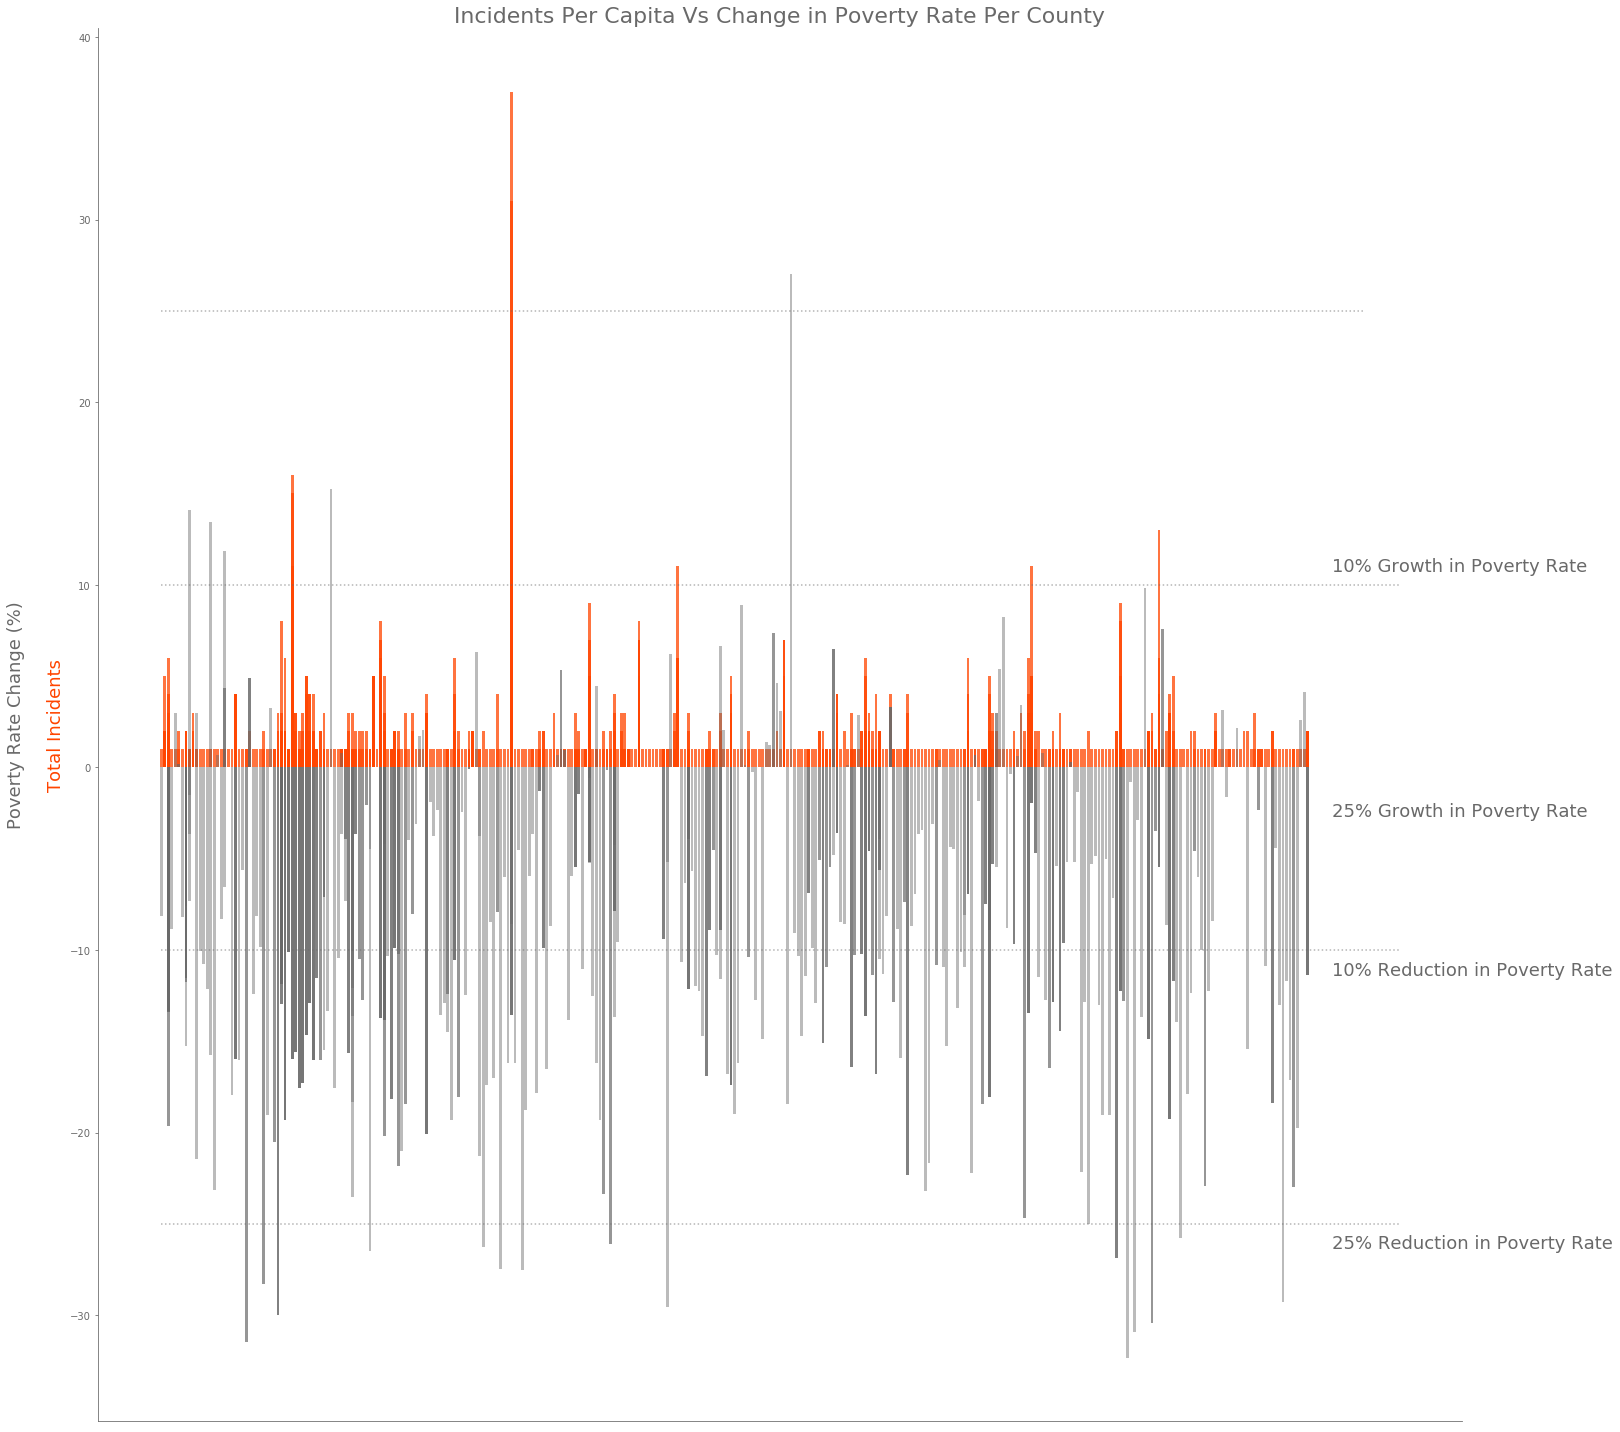

In [1272]:

yrs = ['2014','2015','2016','2017']
# x = [test["Incidents"][yr] for yr in yrs]
colors = ['#ffc266', '#ff7a33', '#ff3300', 'dimgray']

with plt.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
# fig.suptitle("Metastatic Spread During Treatment", fontsize=12, x = .51, y = .93)
fig.set_size_inches(20, 20, forward=True)

# for i in range(0, len(y)):
#     ax.scatter(x, y[i], c = colors[i])
    
# ax.bar(x, v*10000, color = 'lightgray')
# for i in range(0, len(y)):

ax.bar(x,inc, color = 'orangered', alpha = .75)
ax.bar(x,pv, color = 'dimgray', alpha = .45)
# ax.plot(x, 10, color = 'dimgray', alpha = .5)
ax.hlines(25, 0, 340, color = 'dimgray', alpha = .5, linestyles=':', label="25% Poverty Rate Decrease")
ax.hlines(10, 0, 350, color = 'dimgray', alpha = .5, linestyles=':', label="10% Poverty Rate Increase")
ax.hlines(-10, 0, 350, color = 'dimgray', alpha = .5, linestyles=':', label="10% Poverty Rate Decrease")
ax.hlines(-25, 0, 350, color = 'dimgray', alpha = .5, linestyles=':', label="25% Poverty Rate Decrease")
# ax.hlines(-50, 0, 104, color = 'dimgray', alpha = .5, linestyles=':')
# ax.scatter(x,inc, color = 'orangered', edgecolor = 'black', linewidth = .25)

# Format plot with grid, labels, and legend
# plt.grid()
# plt.title("Incidents Vs Poverty Rate Per County")

# ax.set_xlabel("Poverty Rate (%)", color = 'dimgray')
ax.set_ylabel("Poverty Rate Change (%)", color = 'dimgray')
ax.set_ylabel("Total Incidents", color = 'orangered', labelpad = 5, fontsize = 18)
# ax.tick_params(axis=y, color='dimgray')
ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.figtext(-0.02, .57, "Poverty Rate Change (%)", rotation = 90, fontsize = 18)

plt.figtext(.9, .6, "10% Growth in Poverty Rate", fontsize = 18, color='dimgray')
plt.figtext(.9, .43, "25% Growth in Poverty Rate", fontsize = 18, color='dimgray')
plt.figtext(.9, .32, "10% Reduction in Poverty Rate", fontsize = 18, color='dimgray')
plt.figtext(.9, .13, "25% Reduction in Poverty Rate", fontsize = 18, color='dimgray')
# ax.set_xlim(0, 40)
# ax.set_ylim(-0.25,8)
# ax.set_xticks(color='white')
plt.title(f"Incidents Per Capita Vs Change in Poverty Rate Per County", fontsize=22, color = 'dimgray')

# ax.xtick_labels(labels = None)

# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]
plt.tight_layout()

# Save and print
plt.savefig("Images/PovertyRateVsIncidentsCounty")
plt.show()

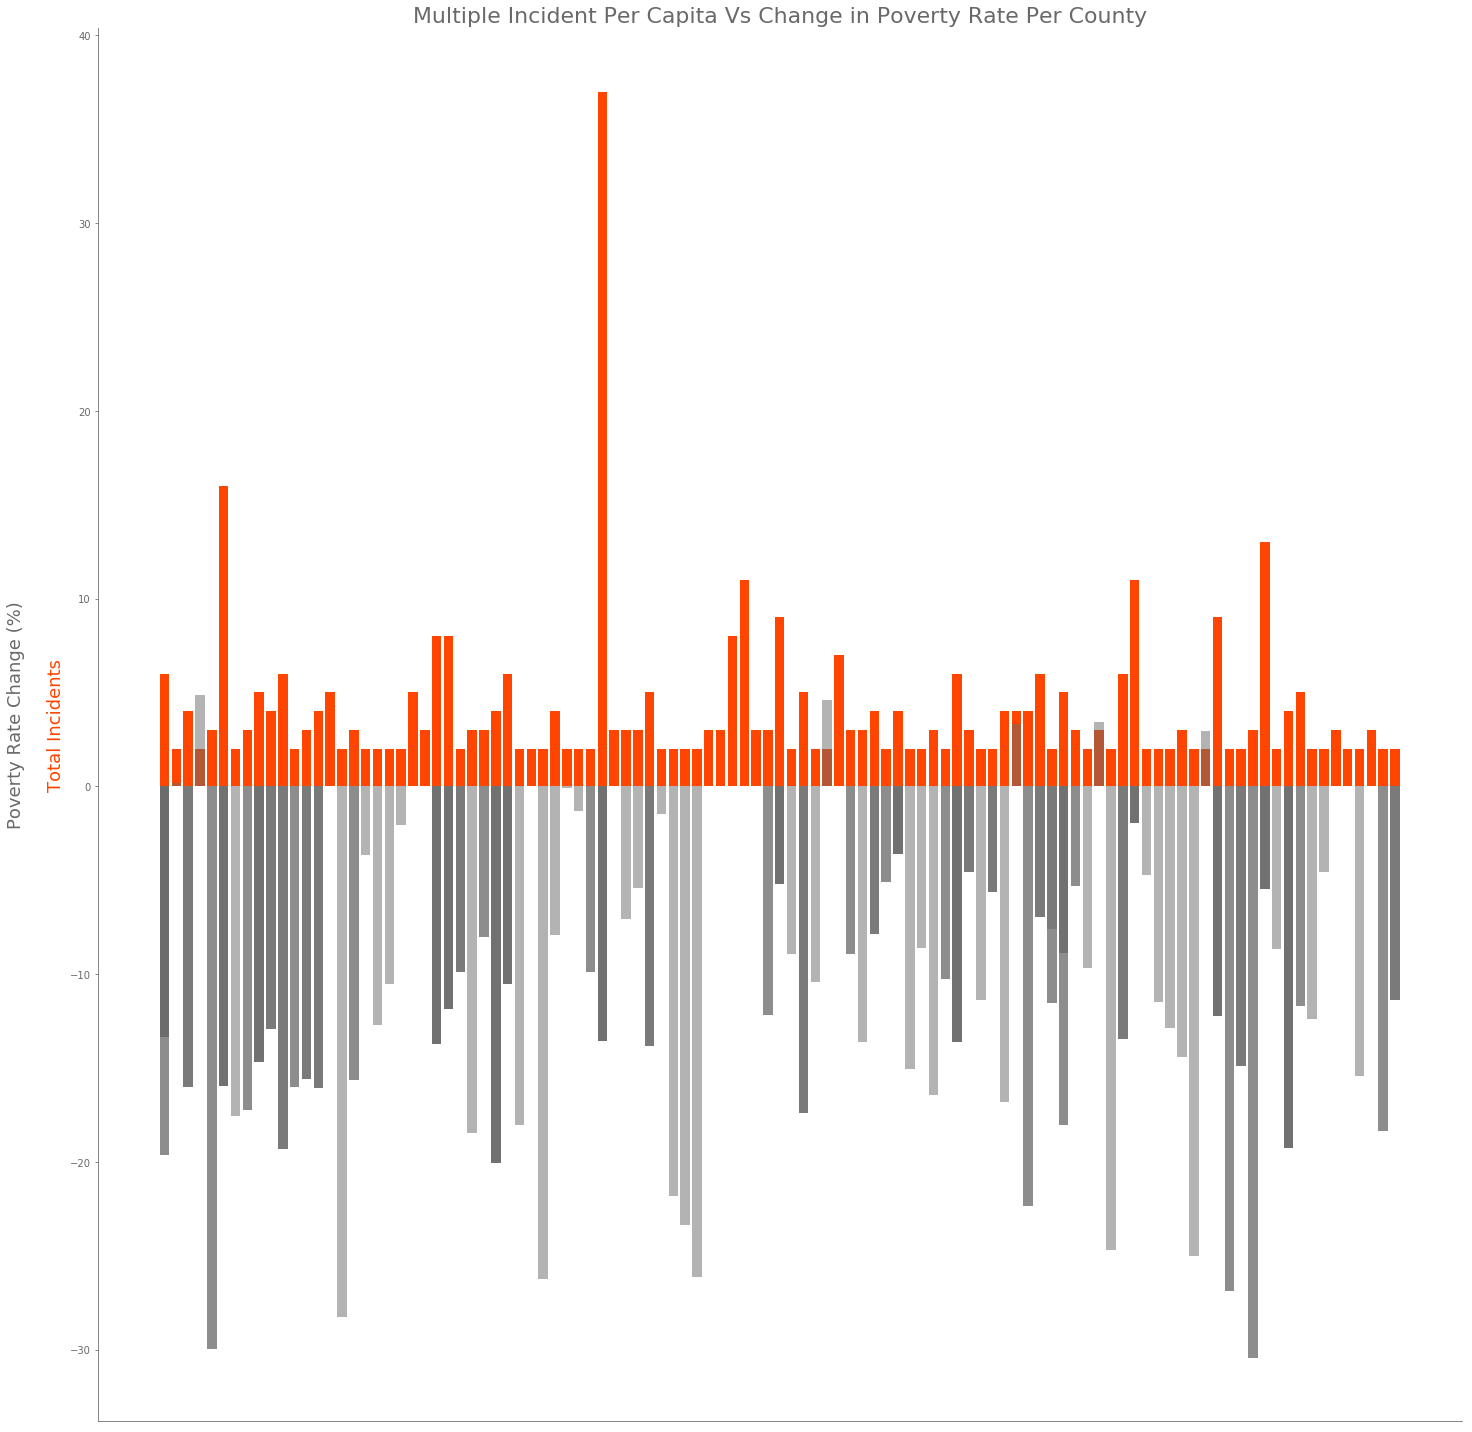

In [1231]:
again = trying[trying["Incidents"]>1]

x = again['County']
pv = again['Poverty Rate Change Avg (%)']
inc = again['Incidents']
len(x)


yrs = ['2014','2015','2016','2017']
# x = [test["Incidents"][yr] for yr in yrs]
colors = ['#ffc266', '#ff7a33', '#ff3300', 'dimgray']

with plt.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
# fig.suptitle("Metastatic Spread During Treatment", fontsize=12, x = .51, y = .93)
fig.set_size_inches(20, 20, forward=True)

# for i in range(0, len(y)):
#     ax.scatter(x, y[i], c = colors[i])
    
# ax.bar(x, v*10000, color = 'lightgray')
# for i in range(0, len(y)):

ax.bar(x,inc, color = 'orangered')
ax.bar(x,pv, color = 'dimgray', alpha = .5)
# ax.scatter(x,inc, color = 'orangered', edgecolor = 'black', linewidth = .25)

# Format plot with grid, labels, and legend
# plt.grid()
# plt.title("Incidents Vs Poverty Rate Per County")

# ax.set_xlabel("Poverty Rate (%)", color = 'dimgray')
ax.set_ylabel("Poverty Rate Change (%)", color = 'dimgray')
ax.set_ylabel("Total Incidents", color = 'orangered', labelpad = 5, fontsize = 18)
# ax.tick_params(axis=y, color='dimgray')
ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.figtext(-0.02, .57, "Poverty Rate Change (%)", rotation = 90, fontsize = 18)
# ax.set_xlim(0, 40)
# ax.set_ylim(-0.25,8)
# ax.set_xticks(color='white')
plt.title(f"Multiple Incident Per Capita Vs Change in Poverty Rate Per County", fontsize=22, color = 'dimgray')

# ax.xtick_labels(labels = None)

# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]
plt.tight_layout()

# Save and print
# plt.savefig("Images/PovertyRateVsIncidentsCounty")
plt.show()

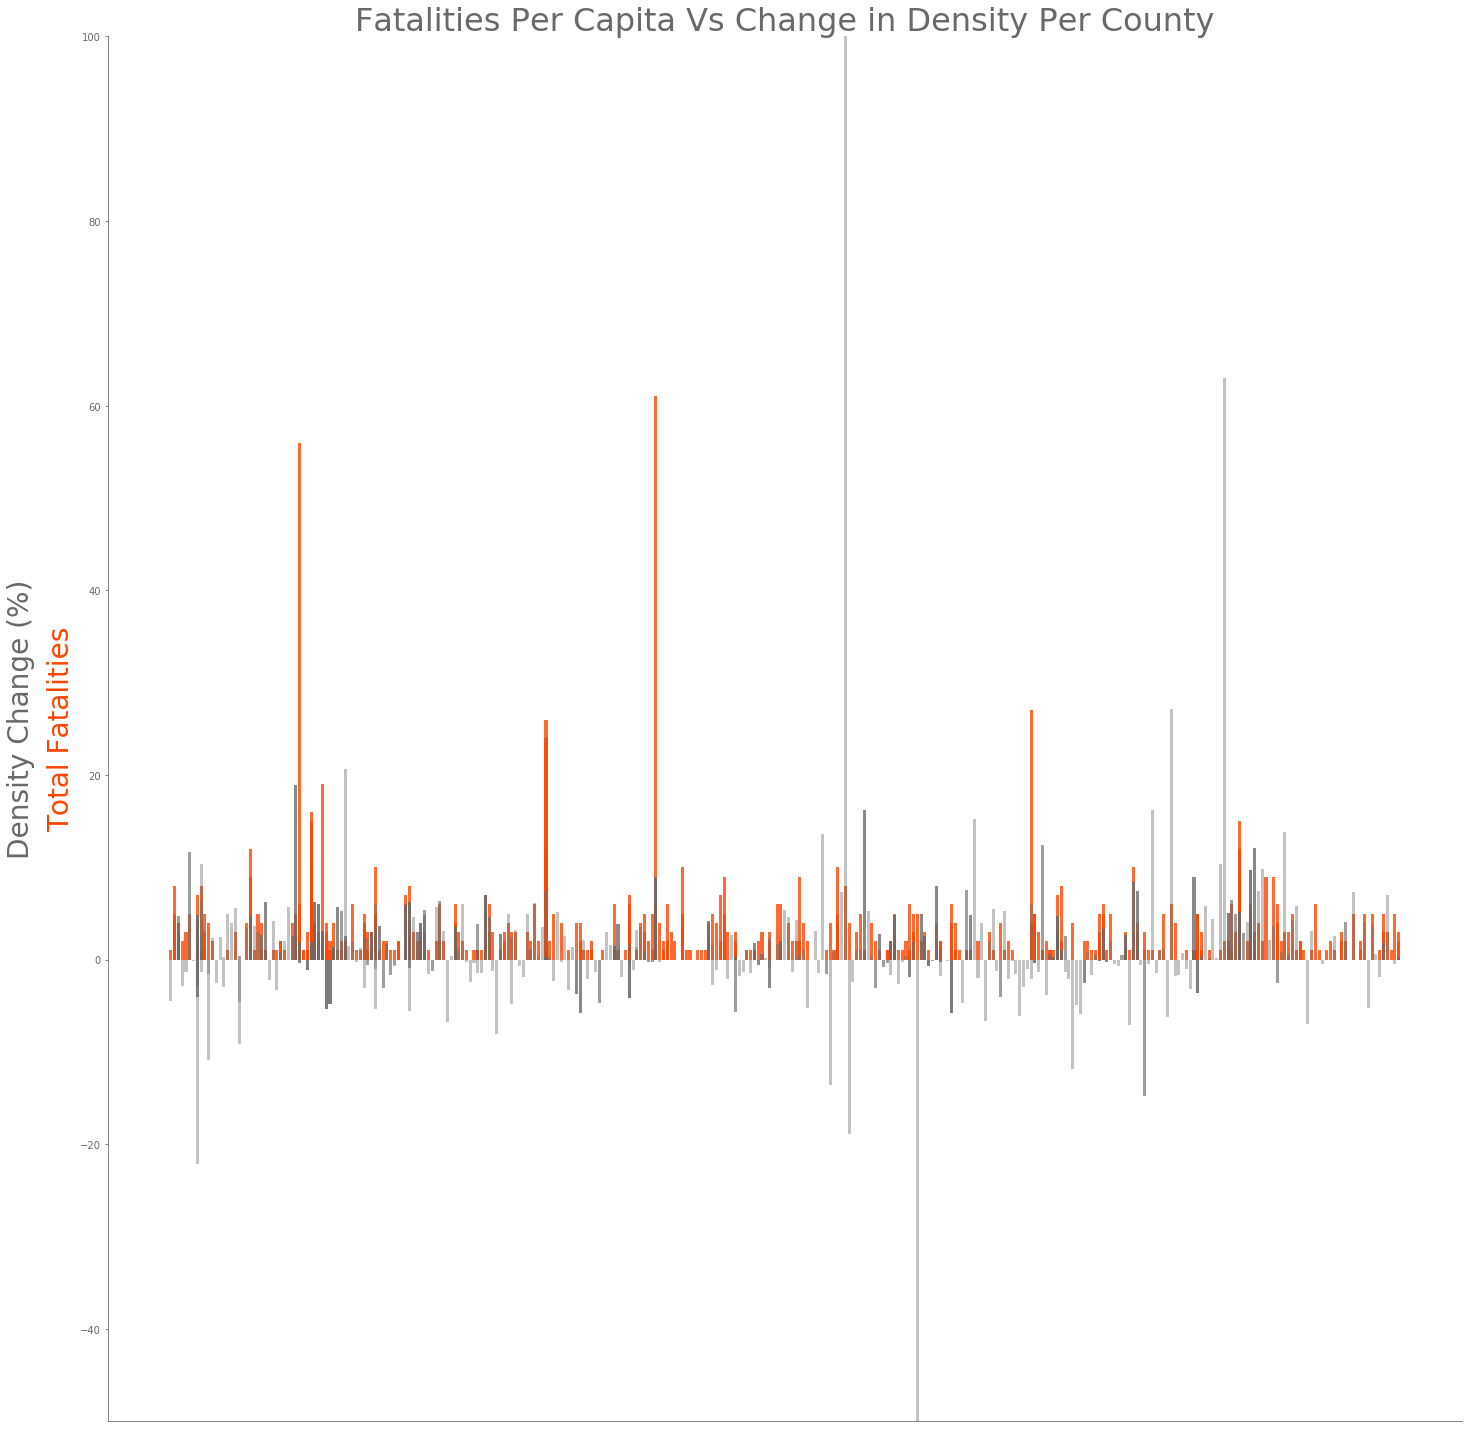

In [1188]:
yrs = ['2014','2015','2016','2017']
# x = [test["Incidents"][yr] for yr in yrs]
colors = ['#ffc266', '#ff7a33', '#ff3300', 'dimgray']

with plt.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
# fig.suptitle("Metastatic Spread During Treatment", fontsize=12, x = .51, y = .93)
fig.set_size_inches(20, 20, forward=True)

# for i in range(0, len(y)):
#     ax.scatter(x, y[i], c = colors[i])
    
# ax.bar(x, v*10000, color = 'lightgray')
# for i in range(0, len(y)):

ax.bar(x,f, color = 'orangered', alpha = .8)
ax.bar(x,d, color = 'dimgray', alpha = .4)
# ax.scatter(x,inc, color = 'orangered', edgecolor = 'black', linewidth = .25)

# Format plot with grid, labels, and legend
# plt.grid()
# plt.title("Incidents Vs Poverty Rate Per County")

# ax.set_xlabel("Poverty Rate (%)", color = 'dimgray')
ax.set_ylabel("Density Change (%)", color = 'dimgray')
ax.set_ylabel("Total Fatalities", color = 'orangered', labelpad = 5, fontsize = 28)
# ax.tick_params(axis=y, color='dimgray')
ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.figtext(-0.02, .58, "Density Change (%)", rotation = 90, fontsize = 28)
# ax.set_xlim(0, 40)
ax.set_ylim(-50,100)
# ax.set_xticks(color='white')
plt.title(f"Fatalities Per Capita Vs Change in Density Per County", fontsize=32, color = 'dimgray')

# ax.xtick_labels(labels = None)

# lgnd = plt.legend(fontsize = 'small', title = "Density Types", loc = 'upper right')
# [handle.set_sizes([40]) for handle in lgnd.legendHandles]
plt.tight_layout()

# Save and print
# plt.savefig("Images/PovertyRateVsIncidentsCounty")
plt.show()

In [1193]:
# trying.head()

# regress = trying[["State","County","Incidents","Injured","Killed","Victims","Den Change Avg (%)","Poverty Rate Change Avg (%)", "Density 2017"]]
# regress["Type"] = 0
regress = trying[["State","County","Incidents","Injured","Killed","Victims","Population 2017", "Density 2017","Pop Change Avg (%)","Den Change Avg (%)","Poverty Rate Change Avg (%)", "Region"]]
regress = regress.rename(columns={"Density 2017":"Density", "Population 2017":"Population"})

In [1194]:
for x in range(0, len(regress)):
    
    if regress["Density"][x] > 3000:
        regress.loc[x, "Type"] = "Urban"
        
    elif 1000 < regress["Density"][x] < 3000:
        regress.loc[x, "Type"] = "Suburban"
        
    else:
        regress.loc[x, "Type"] = "Rural"
        
regress

,State,County,Incidents,Injured,Killed,Victims,Population,Density,Pop Change Avg (%),Den Change Avg (%),Poverty Rate Change Avg (%),Region,Type
0,Alabama,Covington,1,4,1,5,36490.0,58.272425,-34.507726,-4.529812,-8.127377,Southeast,Rural
1,Alabama,None,1,4,0,4,NaN,NaN,NaN,NaN,NaN,Southeast,Rural
2,Alabama,Jefferson,2,10,0,10,643726.0,1688.803627,-33.528489,4.681391,-19.642199,Southeast,Suburban
3,Alabama,Chambers,1,7,2,9,33242.0,132.745678,-33.978953,-2.852340,-8.843966,Southeast,Rural
4,Alabama,Autauga,1,1,3,4,55021.0,118.024495,0.115435,-1.385084,2.998864,Southeast,Rural
5,Alabama,Mobile,1,4,0,4,406795.0,32.448766,-33.410753,11.699381,0.197692,Southeast,Rural
6,Alabama,Tallapoosa,1,5,0,5,40059.0,44.982089,-34.367970,-0.171719,-8.169822,Southeast,Rural
7,Alabama,Montgomery,1,3,1,4,217404.0,641.148325,0.192457,-2.802342,-11.777902,Southeast,Rural
8,Alabama,Mobile,2,5,5,10,406795.0,32.448766,-33.410753,11.699381,0.197692,Southeast,Rural
9,Alabama,Pike,1,4,1,5,31085.0,74.039479,-0.648130,-1.329396,-1.529887,Southeast,Rural


In [1195]:
grouped = regress.groupby(['State', 'County'])

In [1224]:
statsToGraph = grouped.agg({
    "Incidents":['sum'], "Injured":['sum'],"Killed":['sum'], "Victims":['sum'], 
    "Den Change Avg (%)":['last'], "Poverty Rate Change Avg (%)":['last'], "Population":['mean'], 
    "Type":['last'], "Region":['last'], "Pop Change Avg (%)":['last']})
statsToGraph.columns = statsToGraph.columns.droplevel(1)

In [1225]:
statsToGraph.head()

Incidents  Injured  Killed  Victims  Den Change Avg (%)  \
State   County                                                              
Alabama Autauga           1        1       3        4           -1.385084   
        Blount            1        4       1        5            4.952420   
        Calhoun           1        4       0        4            0.235076   
        Chambers          1        7       2        9           -2.852340   
        Cherokee          1        1       3        4            5.588083   

                  Poverty Rate Change Avg (%)  Population   Type     Region  \
State   County                                                                
Alabama Autauga                      2.998864     55021.0  Rural  Southeast   
        Blount                     -23.154919     57452.0  Rural  Southeast   
        Calhoun                    -15.769434    111883.0  Rural  Southeast   
        Chambers                    -8.843966     33242.0  Rural  Southeast   
        Cherokee                    -8.307336     25518.0  Rural  Southeast   

                  Pop Change Avg (%)  
State   County                        
Alabama Autauga             0.115435  
        Blount              0.173260  
        Calhoun            -1.066851  
        Chambers          -33.978953  
        Cherokee           -1.025018

In [1226]:
statsToGraph["Incidents Per Capita"] = statsToGraph["Incidents"]/statsToGraph["Population"]*100000
statsToGraph["Fatalities Per Capita"] = statsToGraph["Killed"]/statsToGraph["Population"]*100000
statsToGraph["Fatality Rate"] = statsToGraph["Killed"]/statsToGraph["Victims"]*100

In [1227]:
stab = statsToGraph.dropna()

dummies = pd.get_dummies(stab['Type'])
stab = pd.concat([stab, dummies], axis=1)

dummies2 = pd.get_dummies(stab['Region'])
stab = pd.concat([stab, dummies2], axis=1)


stab

Incidents  Injured  Killed  Victims  \
State      County                                                
Alabama    Autauga                 1        1       3        4   
           Blount                  1        4       1        5   
           Calhoun                 1        4       0        4   
           Chambers                1        7       2        9   
           Cherokee                1        1       3        4   
           Coffee                  1        4       0        4   
           Covington               1        4       1        5   
           Dale                    1        4       0        4   
           Elmore                  1        2       2        4   
           Greene                  1        5       0        5   
           Jefferson               6       26       4       30   
           Madison                 1        5       0        5   
           Mobile                  3        9       5       14   
           Montgomery              2        8       1        9   
           Pike                    1        4       1        5   
           Russell                 1       12       0       12   
           Tallapoosa              1        5       0        5   
Arizona    Coconino                1        3       1        4   
           Maricopa               13       44      23       67   
           Pima                    1        0       5        5   
           Pinal                   1        0       4        4   
Arkansas   Craighead               2       10       5       15   
           Crittenden              1        4       0        4   
           Garland                 1        4       1        5   
           Mississippi             1       11       1       12   
           Pulaski                 4       36       3       39   
California Alameda                11       54       2       56   
           Contra Costa            4       17       3       20   
           Fresno                 11       47       3       50   
           Kern                    4       23       5       28   
...                              ...      ...     ...      ...   
Texas      Nueces                  2        5       3        8   
           Potter                  1        4       0        4   
           Smith                   1        3       1        4   
           Starr                   1        2       2        4   
           Tarrant                 7       32       6       38   
           Travis                  5       14       7       21   
           Webb                    1        3       2        5   
           Williamson              1        3       2        5   
           Wilson                  1       20      27       47   
Utah       Salt Lake               2        8       3       11   
           Utah                    1        0       5        5   
Vermont    Washington              1        0       4        4   
Virginia   Brunswick               1        7       0        7   
           Culpeper                1        0       5        5   
           Gloucester              1        3       1        4   
           Halifax                 1        5       0        5   
           Henrico                 2        8       1        9   
           Northampton             1        3       1        4   
           Prince William          2        6       2        8   
           Washington              1        1       5        6   
Washington Cowlitz                 1        1       3        4   
           King                    5       21       3       24   
           Mason                   1        0       5        5   
           Pierce                  1        5       0        5   
           Skagit                  1        0       5        5   
           Snohomish               2        2       8       10   
           Spokane                 1        3       1        4   
           Yakima                  1        6       0        6   
W

In [1228]:
## Regression

import statsmodels.api as sm
import statsmodels.formula.api as smf


# x_data = stab[['Poverty Rate Change Avg (%)', 'Den Change Avg (%)', 'Rural', 'Suburban', 'Urban']]
x_data = stab[['Poverty Rate Change Avg (%)', 'Rural', 'Southeast']]

y_data = stab['Incidents Per Capita']

##Adding constant term to the linear regression model
x_data = sm.add_constant(x_data)

model = sm.OLS(y_data, x_data).fit()
predictions = model.predict(x_data)

result = model.summary()
print(result)

                             OLS Regression Results                             
Dep. Variable:     Incidents Per Capita   R-squared:                       0.201
Model:                              OLS   Adj. R-squared:                  0.194
Method:                   Least Squares   F-statistic:                     27.72
Date:                  Sat, 30 Mar 2019   Prob (F-statistic):           5.18e-16
Time:                          11:35:39   Log-Likelihood:                -706.36
No. Observations:                   334   AIC:                             1421.
Df Residuals:                       330   BIC:                             1436.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [1229]:
# x_data = stab[['Den Change Avg (%)', 'Poverty Rate Change Avg (%)', 'Rural', 'Suburban', 'Urban']]
x_data = stab[['Den Change Avg (%)', 'Rural', 'Southeast']]
y_data = stab['Fatalities Per Capita']

##Adding constant term to the linear regression model
x_data = sm.add_constant(x_data)

model = sm.OLS(y_data, x_data).fit()
predictions = model.predict(x_data)

print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     Fatalities Per Capita   R-squared:                       0.098
Model:                               OLS   Adj. R-squared:                  0.089
Method:                    Least Squares   F-statistic:                     11.90
Date:                   Sat, 30 Mar 2019   Prob (F-statistic):           2.03e-07
Time:                           11:35:43   Log-Likelihood:                -1172.7
No. Observations:                    334   AIC:                             2353.
Df Residuals:                        330   BIC:                             2369.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const 

In [1275]:
# x_data = stab[['Den Change Avg (%)', 'Poverty Rate Change Avg (%)', 'Rural', 'Suburban', 'Urban']]
x_data = stab[['Pop Change Avg (%)', 'Rural','Northeast']]
y_data = stab['Fatality Rate']

##Adding constant term to the linear regression model
x_data = sm.add_constant(x_data)

model = sm.OLS(y_data, x_data).fit()
predictions = model.predict(x_data)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Fatality Rate   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     10.23
Date:                Sat, 30 Mar 2019   Prob (F-statistic):           1.86e-06
Time:                        12:17:30   Log-Likelihood:                -1590.3
No. Observations:                 334   AIC:                             3189.
Df Residuals:                     330   BIC:                             3204.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 22.0234      2

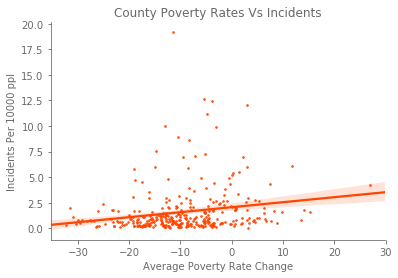

In [1101]:
import seaborn as sns

sns.set_style({'axes.edgecolor': 'dimgray', 'axes.labelcolor': 'dimgray', 'xtick.color': 'dimgray', 'ytick.color': 'dimgray', 'axes.spines.top': False,'axes.spines.right': False, 'text.color':'dimgray'})
ax = sns.regplot(x='Poverty Rate Change Avg (%)', y='Incidents Per Capita', data=stab, color='orangered', marker = 'o', scatter_kws = {'s':3})
ax.set(xlabel='Average Poverty Rate Change', ylabel = 'Incidents Per 10000 ppl', title = "County Poverty Rates Vs Incidents")
plt.savefig("PovertyVsIncidentsRegressionLine")
plt.show()

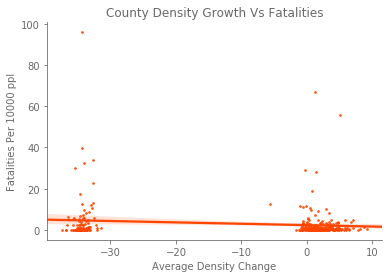

In [1210]:
import seaborn as sns

sns.set_style({'axes.edgecolor': 'dimgray', 'axes.labelcolor': 'dimgray', 'xtick.color': 'dimgray', 'ytick.color': 'dimgray', 'axes.spines.top': False,'axes.spines.right': False, 'text.color':'dimgray'})
ax = sns.regplot(x='Pop Change Avg (%)', y='Fatalities Per Capita', data=stab, color='orangered', marker = 'o', scatter_kws = {'s':3})
ax.set(xlabel='Average Density Change', ylabel = 'Fatalities Per 10000 ppl', title = "County Density Growth Vs Fatalities")
plt.savefig("PovertyVsIncidentsRegressionLine")
plt.show()

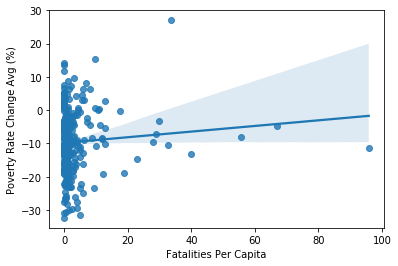

In [1058]:

sns.regplot(x='Fatalities Per Capita', y='Poverty Rate Change Avg (%)', data=stab, truncate=Tr
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ju  7777777777777777777777ue)

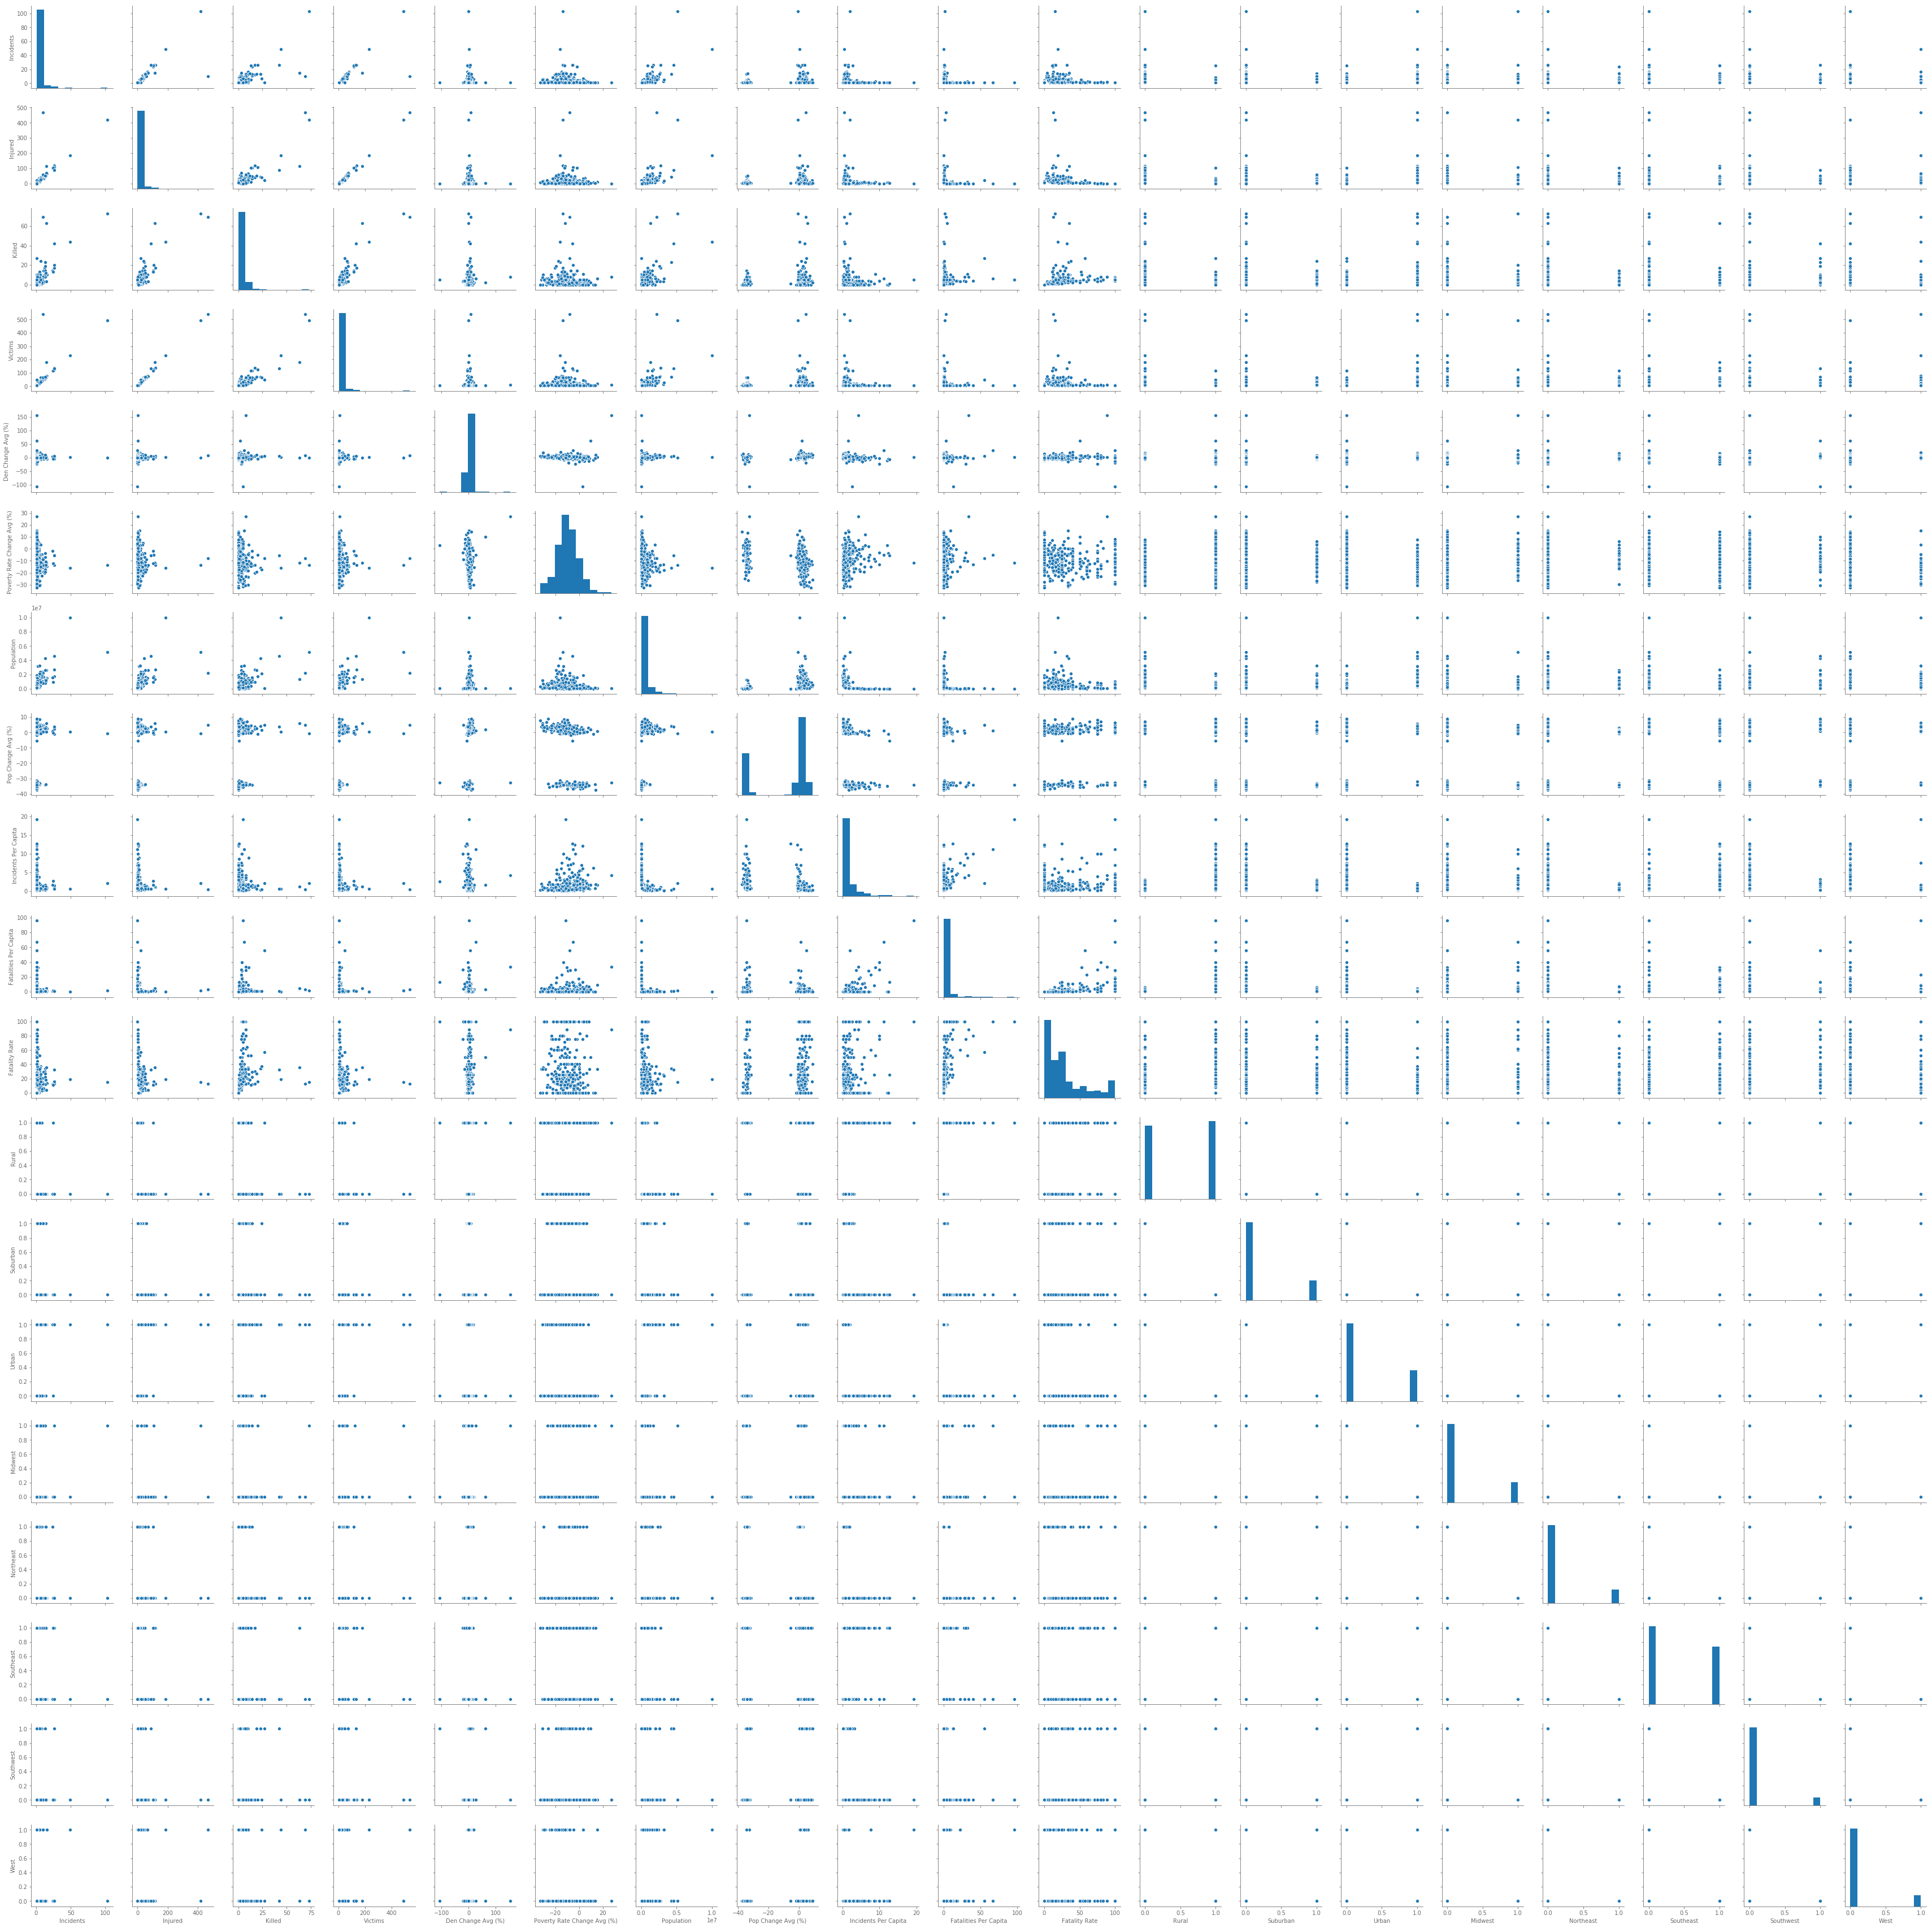

In [1276]:
sns.pairplot(stab)
plt.show()